In [1]:
import os
from datetime import datetime
import pandas as pd
import collections
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
EPSILON = 0.01

In [3]:
def weighted_median(data, weights):

    data, weights = np.array(data).squeeze(), np.array(weights).squeeze()
    s_data, s_weights = map(np.array, zip(*sorted(zip(data, weights))))
    midpoint = 0.5 * sum(s_weights)
    if any(weights > midpoint):
        w_median = (data[weights == np.max(weights)])[0]
    else:
        cs_weights = np.cumsum(s_weights)
        idx = np.where(cs_weights <= midpoint)[0][-1]
        if cs_weights[idx] == midpoint:
            w_median = np.mean(s_data[idx:idx+2])
        else:
            w_median = s_data[idx+1]
    return w_median

In [11]:
class NooksExperiment:
    '''
        initializes the network graph which keeps track of all the interactions in nooks
                        nooks graph which tracks the members talking in a single day
    '''
    def _init_graphs(self):
        self.network_graph = nx.Graph()
        self.nooks_graph = nx.Graph()
        
        nft = len(self.member_vectors[0])
        self.graph_colors = []
        
        if nft == 1:
            color = self.member_vectors
        else:
            pca = PCA(n_components=1)
            color = pca.fit_transform(self.member_vectors)
        
        self.graph_colors = color.reshape(-1)
            
        for member in range(self.total_members):
            self.network_graph.add_node(member)
            self.nooks_graph.add_node(member)
    '''
        create a class for the experiment 
            member_vectors: a M x D numpy array where M is the number of members and D is the feature representation
            alpha : the importance placed on heterophily compared to the past interaction rate
    '''
        
    def __init__(self, member_vectors, alpha):
        self.total_members = len(member_vectors)
        self.member_vectors = member_vectors
        self.interacted = np.zeros((self.total_members, self.total_members))
        self.all_interactions = np.zeros((self.total_members, self.total_members))
        self.alpha = alpha
        self._init_graphs()
        
        self.network_output_folder = "Results/" + datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p") + "/Network/"
        self.nooks_output_folder = "Results/" + datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p") + "/Nooks/"
        self.info_output_folder = "Results/" + datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p") + "/Info/" 
        os.makedirs(self.network_output_folder)
        os.makedirs(self.nooks_output_folder)
        os.makedirs(self.info_output_folder)
        
    '''
        resets the interactions (for eg at the end of every week)
    '''
    
    def reset(self):
        self.interacted = np.zeros((self.total_members, self.total_members))
    
    '''
        called to update the interactions, also updates the total interactions during the experiment
    
    '''
    def _update_interacted(self, member_allocs, nooks_allocs):
        for member in range(self.total_members):
            if not member in member_allocs:
                continue
            self.interacted[member] += nooks_allocs[member_allocs[member]]
            self.all_interactions[member] += nooks_allocs[member_allocs[member]]
    
    # TODO see if running median is needed; space & time 
    def _create_nook_allocs_it(self, num_nooks, nook_creators, nook_swipes, num_iters=200):
        
        nooks_allocs = np.zeros((num_nooks, self.total_members))
        member_allocs = {}
        creators = set([])
        nooks_mem_cnt = np.ones((num_nooks))
        nooks_mem_int_cnt = np.zeros((num_nooks, self.total_members))
                            
        # allocates the creator to their respective nooks
        for nook in range(num_nooks):
            nooks_allocs[nook][nook_creators[nook]] = 1
            member_allocs[nook_creators[nook]] = nook
            creators.add(nook_creators[nook])
        
        # iteratively add members to nooks
        for member in range(self.total_members):
            if member in member_allocs or not(np.sum(nook_swipes[member])):
                continue
            
            swipes = nook_swipes[member]
            median_reps = []
            selected_nook = np.random.choice(num_nooks, p=swipes/np.sum(swipes))
            nooks_allocs[selected_nook][member] = 1
            member_allocs[member] = selected_nook
            nooks_mem_cnt[selected_nook] += 1
            nooks_mem_int_cnt += (self.interacted[member] >= 1)
            
        all_members_permute = np.random.permutation(self.total_members)
        for i in range(num_iters):
            
            for member in all_members_permute:
                if member in creators or not(np.sum(nook_swipes[member])):
                    continue
            
                swipes = nook_swipes[member]
                median_reps = []
            
            
                for nook in range(num_nooks):
                    if not nook_swipes[member][nook]:
                        median_reps.append(1) # this value will be ignored
                        continue
                    median_rep = np.median(self.member_vectors[nooks_allocs[nook]==1], axis=0)
                    median_reps.append(np.linalg.norm(self.member_vectors[member]-median_rep))
            
                heterophily = (np.array(median_reps))
                interacted_by = nooks_mem_int_cnt[:, member] 
                wts = ((EPSILON + interacted_by)/nooks_mem_cnt) * (1 + self.alpha * heterophily)
                
                sel_wts = wts * nook_swipes[member]
                
                total_sel_wts = np.sum(sel_wts)
                selected_nook = np.argmax(sel_wts/total_sel_wts)
                og_nook = member_allocs[member]
                if not(selected_nook == og_nook):
                    
                    nooks_allocs[selected_nook][member] = 1
                    nooks_allocs[og_nook][member] = 0
                    
                    nooks_mem_cnt[selected_nook] += 1
                    nooks_mem_cnt[og_nook] -= 1
                    
                    
                    member_allocs[member] = selected_nook
                    nooks_mem_int_cnt[selected_nook] += (self.interacted[member] >= 1)
                    nooks_mem_int_cnt[og_nook] -= (self.interacted[member] >= 1)
                    
                    
                #np.random.choice(num_nooks, p=sel_wts/total_sel_wts)
            
                
                
                
                
            
            
        self._update_interacted(member_allocs, nooks_allocs)
        return member_allocs, nooks_allocs
    
    
    
    '''
        creates the nook allocations in an iterative manner.
        assumes that 1 creator has only created 1 nook
    
    '''
    # TODO see if running median is needed; space & time 
    def _create_nook_allocs(self, num_nooks, nook_creators, nook_swipes):
        
        nooks_allocs = np.zeros((num_nooks, self.total_members))
        member_allocs = {}
        nooks_mem_cnt = np.ones((num_nooks))
        nooks_mem_int_cnt = np.zeros((num_nooks, self.total_members))
                            
        # allocates the creator to their respective nooks
        for nook in range(num_nooks):
            nooks_allocs[nook][nook_creators[nook]] = 1
            member_allocs[nook_creators[nook]] = nook
            nooks_mem_cnt[nook] += 1
            nooks_mem_int_cnt[nook] += self.interacted[nook_creators[nook]]
            
        all_members_permute = np.random.permutation(self.total_members)
        
        # iteratively add members to nooks
        for member in all_members_permute:
            if member in member_allocs or not(np.sum(nook_swipes[member])):
                continue
            
            swipes = nook_swipes[member]
            median_reps = []
            
            for nook in range(num_nooks):
                if not nook_swipes[member][nook]:
                    median_reps.append(1) # this value will be ignored
                    continue
                
                median_rep = np.median(self.member_vectors[nooks_allocs[nook]==1], axis=0)
                #print(self.member_vectors.shape, nooks_allocs.shape, nooks_allocs[nook]==1, median_rep.shape)
                
                median_reps.append(np.linalg.norm(self.member_vectors[member]-median_rep))
            
            heterophily = (np.array(median_reps))
            interacted_by = nooks_mem_int_cnt[:, member] 
            wts = ((EPSILON + interacted_by)/nooks_mem_cnt) * (1 + self.alpha * heterophily)
            sel_wts = wts * nook_swipes[member]
            total_sel_wts = np.sum(sel_wts)
            selected_nook = np.argmax(sel_wts/total_sel_wts)
            #np.random.choice(num_nooks, p=sel_wts/total_sel_wts)
            
            nooks_allocs[selected_nook][member] = 1
            member_allocs[member] = selected_nook
            nooks_mem_cnt[selected_nook] += 1
            nooks_mem_int_cnt[selected_nook] += self.interacted[member]
            
        self._update_interacted(member_allocs, nooks_allocs)
        return member_allocs, nooks_allocs

    '''
        update the graph for the present days nooks
    
    '''
    def _update_nooks_graph(self, member_allocs, day=0):
        print("______NOOKS_________" )
        self.nooks_graph.remove_edges_from(list(self.nooks_graph.edges()))
        for m1 in range(self.total_members):
            if m1 not in member_allocs:
                continue
            for m2 in range(m1):
                if m2 not in member_allocs:
                    continue
                if member_allocs[m1] == member_allocs[m2]:
                    self.nooks_graph.add_edge(m1, m2, weight=self.all_interactions[m1, m2])
        weights = [self.nooks_graph[u][v]['weight'] for u,v in self.nooks_graph.edges()]
        nx.draw(self.nooks_graph, node_color=self.graph_colors, width=weights)
        print("DAY " + str(day))
        plt.show()
        #plt.savefig(os.path.join(self.nooks_output_folder, "day_"+ str(day) + ".png"))
        plt.close()
        
    '''
        update the overall network based on interactions taken place on the current day
    '''    
    def _update_network_graph(self, member_allocs, day=0, print_summary=False):
        print("______NETWORK_________" )
        self.network_graph.remove_edges_from(list(self.network_graph.edges()))
        for m1 in range(self.total_members):
            for m2 in range(m1):
                if self.all_interactions[m1, m2]:
                    self.network_graph.add_edge(m1, m2, weight=self.all_interactions[m1, m2])
                    
        weights = [self.network_graph[u][v]['weight'] for u,v in self.network_graph.edges()]
        nx.draw(self.network_graph, node_color=self.graph_colors, width=weights)
        plt.show()
        plt.close()
        if not print_summary:
            return
        
        top_neighbors = []
        for n in range(self.total_members):
            neighbors = np.array([self.member_vectors[m] for m in self.network_graph.neighbors(n) if not(m==n)])
            if not len(neighbors):
                continue
            neighbors = neighbors.reshape(-1)
            edge_weights = np.array([self.network_graph.edges[n, m]['weight'] for m in self.network_graph.neighbors(n) if not(m==n)])
            
            #print(weighted_neighbors.shape, self.member_vectors.shape)
            total_weights = np.sum(edge_weights)
            edge_weights_norm = (edge_weights/total_weights).reshape(-1)
            
            median_rep = weighted_median(neighbors, edge_weights)
            tn = [[self.network_graph.edges[n, m]['weight'], np.linalg.norm(self.member_vectors[n]-self.member_vectors[m])] for m in self.network_graph.neighbors(n) if not(m==n)]
            tn.sort(reverse=True)
            tn = np.mean(np.array(tn)[:, 1][:5])
            top_neighbors.append([self.member_vectors[n], tn, np.linalg.norm(self.member_vectors[n]-median_rep)])
            #print(self.member_vectors[n], [self.member_vectors[m] for m in top_neighbors])
        df = pd.DataFrame(top_neighbors)
        print(df[[0,1]])
        plt.plot(range(len(top_neighbors)), list(df[1]))
        plt.show()
        plt.close()
        df.to_csv(os.path.join(self.info_output_folder, str(day)))
        print(np.mean(df[1]))
        #print(df)
        #nx.write_gexf(self.network_graph, "test.gexf")
        #plt.savefig(os.path.join(self.network_output_folder, "day_"+ str(day) + ".png"))
                             
                                                
    def _update_graphs(self, member_allocs, day=0, print_summary=False):
        self._update_network_graph(member_allocs, day, print_summary=print_summary)
        self._update_nooks_graph(member_allocs, day)
    
    '''
        create num_nooks number of nooks and allocate a random member as its creator
        returns a numpy array(say nooks) of shape (num_nooks,) where nooks[n] is the creator of the nth nook
    '''
    # assumes we only pop off atmost 1 story created by a member
    def _create_nooks(self, num_nooks):
        return np.random.choice(self.total_members, size=num_nooks, replace=False)
    '''
        creates a list of random swipes
        returns a np array(say swipes) of shape (self.total_members, num_nooks) where swipe[m][n] = 1 if member m swiped right else is 0
    '''
    def _create_random_swipes(self, num_nooks):
        #return np.ones((self.total_members, num_nooks))
        return np.random.randint(2, size=(self.total_members, num_nooks))
            
    
    '''
        run the experiment for a total of num_days
                    reset_time: the time after which the interactions are deleted
                    save_time: time after which data should be saved locally
                    graph_time: time after which graphs should be plotted
                    num_nooks_mode: can either be uniform or random, uniform means same number of stories per day, random means changing number of stories
                                if the num_nooks_mode is uniform, also add in argument num_nooks
                                if it is random, add min_nooks and max_nooks as arguments while calling run
    '''
    def run(self, num_days=100, reset_time=7, save_time=1, graph_time=1, num_nooks_mode='uniform', **kwargs):
        if num_nooks_mode not in ['uniform', 'random']:
            raise "Experiment run mode not implemented"
            return 
        if num_nooks_mode == 'uniform':
            num_nooks = kwargs["num_nooks"]
            
        for i in range(num_days):
            print_summary = False
            
            if not i % reset_time:
                self.reset()
                
                
            if not i % save_time:
                print_summary = True
                
                            
            if num_nooks_mode == 'random':
                num_nooks = np.random.randint(kwargs["min_nooks"], kwargs["max_nooks"])

            nook_creators = self._create_nooks(num_nooks) 
            nook_swipes = self._create_random_swipes(num_nooks)
            member_allocs, nooks_allocs = self._create_nook_allocs_it(num_nooks, nook_creators, nook_swipes)
            
            if not i % graph_time:
                self._update_graphs(member_allocs=member_allocs, day=i, print_summary=print_summary)
        

______NETWORK_________


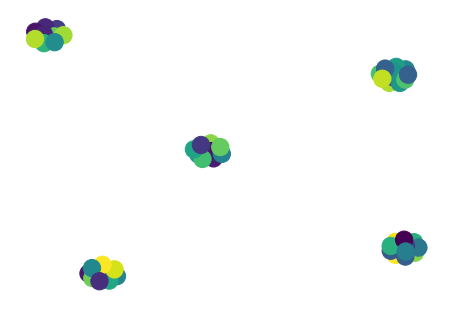

                        0         1
0    [0.9619107455346222]  0.741983
1   [0.06441444674001473]  0.761702
2    [0.7891942715303771]  0.569267
3     [0.177226238283531]  0.522423
4    [0.9440371060941252]  0.655123
5    [0.6091959154527136]  0.414848
6     [0.839591919659533]  0.496539
7    [0.4406367464203794]  0.434026
8    [0.6775089279258867]  0.337116
9   [0.17855500858877416]  0.544234
10  [0.28493851781217705]  0.496223
11  [0.11384921261232228]  0.585800
12   [0.5158618344686122]  0.291048
13   [0.9333196008170971]  0.713392
14  [0.44673635143702617]  0.312503
15   [0.7510065789639694]  0.462093
16  [0.07845944951476702]  0.567326
17     [0.57412693913227]  0.406823
18   [0.5326677331923972]  0.294410
19   [0.4687401068189414]  0.339571
20  [0.35736784515754816]  0.483987
21  [0.05295805297084666]  0.646692
22   [0.4960445674936236]  0.287085
23   [0.6919055562617197]  0.348853
24   [0.8994784804713435]  0.610565
25  [0.38438243606127953]  0.428102
26   [0.7318488841888736]  0

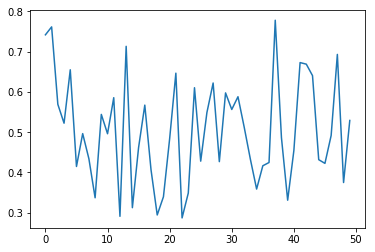

0.5042934937839132
______NOOKS_________
DAY 0


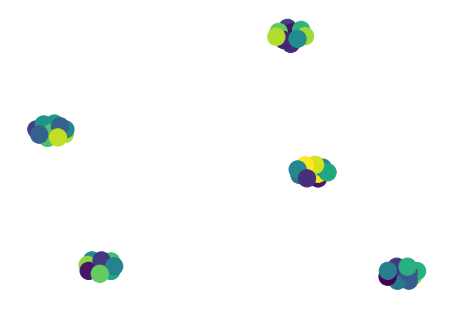

______NETWORK_________


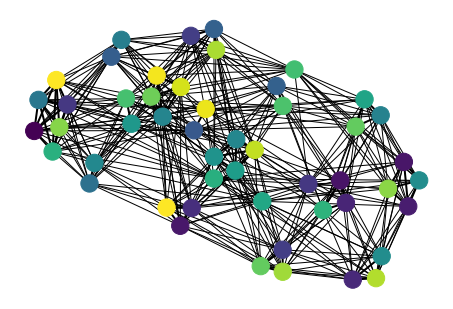

                        0         1
0    [0.9619107455346222]  0.572389
1   [0.06441444674001473]  0.697688
2    [0.7891942715303771]  0.434216
3     [0.177226238283531]  0.671076
4    [0.9440371060941252]  0.486371
5    [0.6091959154527136]  0.526844
6     [0.839591919659533]  0.546190
7    [0.4406367464203794]  0.438573
8    [0.6775089279258867]  0.447077
9   [0.17855500858877416]  0.592126
10  [0.28493851781217705]  0.544729
11  [0.11384921261232228]  0.620218
12   [0.5158618344686122]  0.366797
13   [0.9333196008170971]  0.816270
14  [0.44673635143702617]  0.293765
15   [0.7510065789639694]  0.391336
16  [0.07845944951476702]  0.510470
17     [0.57412693913227]  0.484703
18   [0.5326677331923972]  0.271935
19   [0.4687401068189414]  0.373088
20  [0.35736784515754816]  0.485975
21  [0.05295805297084666]  0.613701
22   [0.4960445674936236]  0.271935
23   [0.6919055562617197]  0.512334
24   [0.8994784804713435]  0.450725
25  [0.38438243606127953]  0.363413
26   [0.7318488841888736]  0

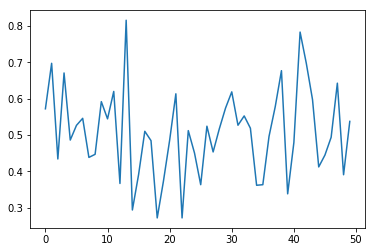

0.5073909085603091
______NOOKS_________
DAY 1


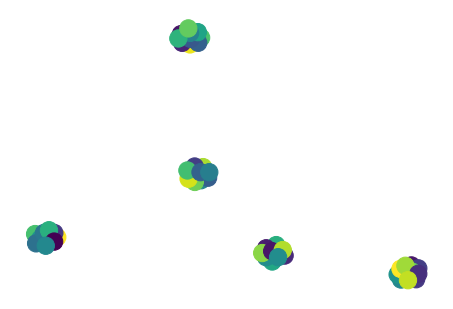

______NETWORK_________


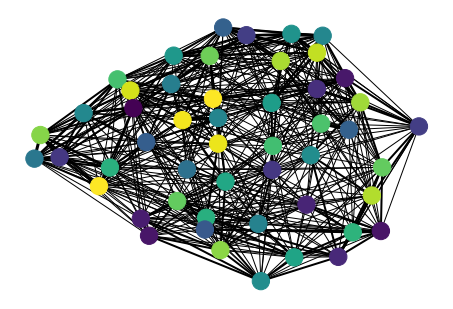

                        0         1
0    [0.9619107455346222]  0.673240
1   [0.06441444674001473]  0.558679
2    [0.7891942715303771]  0.467640
3     [0.177226238283531]  0.406576
4    [0.9440371060941252]  0.354000
5    [0.6091959154527136]  0.427801
6     [0.839591919659533]  0.412562
7    [0.4406367464203794]  0.312360
8    [0.6775089279258867]  0.262646
9   [0.17855500858877416]  0.476797
10  [0.28493851781217705]  0.388734
11  [0.11384921261232228]  0.543013
12   [0.5158618344686122]  0.317221
13   [0.9333196008170971]  0.766130
14  [0.44673635143702617]  0.253694
15   [0.7510065789639694]  0.374049
16  [0.07845944951476702]  0.532460
17     [0.57412693913227]  0.350027
18   [0.5326677331923972]  0.260730
19   [0.4687401068189414]  0.324530
20  [0.35736784515754816]  0.485975
21  [0.05295805297084666]  0.407347
22   [0.4960445674936236]  0.253694
23   [0.6919055562617197]  0.480013
24   [0.8994784804713435]  0.232889
25  [0.38438243606127953]  0.376477
26   [0.7318488841888736]  0

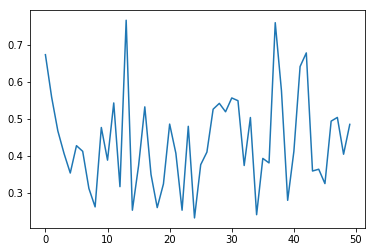

0.43963128509134825
______NOOKS_________
DAY 2


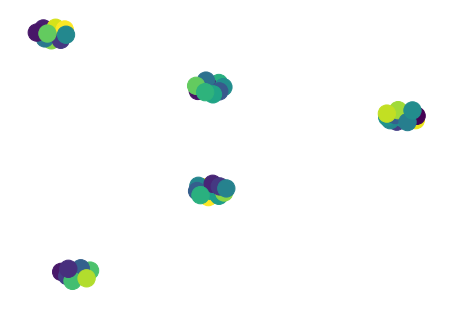

______NETWORK_________


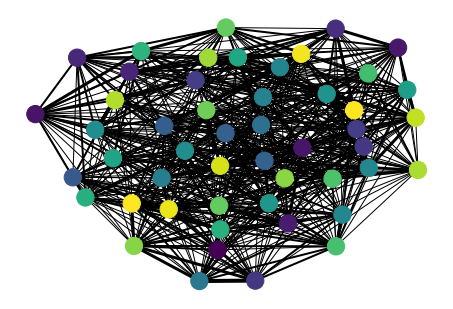

                        0         1
0    [0.9619107455346222]  0.592277
1   [0.06441444674001473]  0.609507
2    [0.7891942715303771]  0.474735
3     [0.177226238283531]  0.458214
4    [0.9440371060941252]  0.637144
5    [0.6091959154527136]  0.366277
6     [0.839591919659533]  0.412562
7    [0.4406367464203794]  0.354545
8    [0.6775089279258867]  0.373944
9   [0.17855500858877416]  0.507777
10  [0.28493851781217705]  0.421642
11  [0.11384921261232228]  0.613961
12   [0.5158618344686122]  0.374101
13   [0.9333196008170971]  0.585929
14  [0.44673635143702617]  0.325094
15   [0.7510065789639694]  0.365137
16  [0.07845944951476702]  0.475575
17     [0.57412693913227]  0.375434
18   [0.5326677331923972]  0.346877
19   [0.4687401068189414]  0.324530
20  [0.35736784515754816]  0.325832
21  [0.05295805297084666]  0.594958
22   [0.4960445674936236]  0.316421
23   [0.6919055562617197]  0.399738
24   [0.8994784804713435]  0.429754
25  [0.38438243606127953]  0.376477
26   [0.7318488841888736]  0

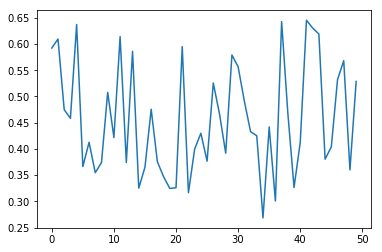

0.45669415451796364
______NOOKS_________
DAY 3


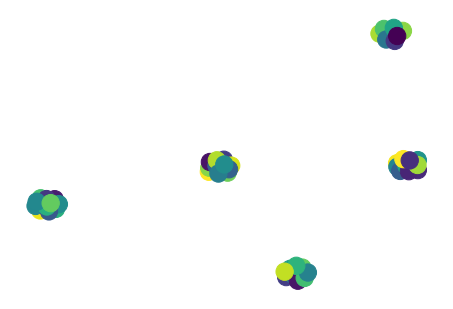

______NETWORK_________


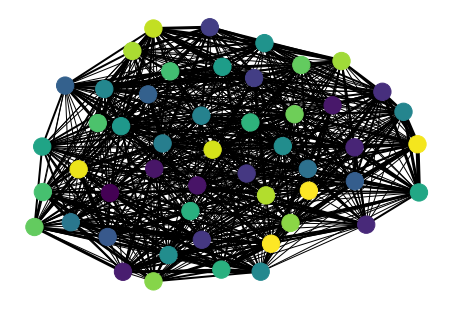

                        0         1
0    [0.9619107455346222]  0.638674
1   [0.06441444674001473]  0.645751
2    [0.7891942715303771]  0.474735
3     [0.177226238283531]  0.571396
4    [0.9440371060941252]  0.637144
5    [0.6091959154527136]  0.411770
6     [0.839591919659533]  0.458587
7    [0.4406367464203794]  0.354545
8    [0.6775089279258867]  0.414569
9   [0.17855500858877416]  0.487327
10  [0.28493851781217705]  0.392785
11  [0.11384921261232228]  0.496309
12   [0.5158618344686122]  0.275248
13   [0.9333196008170971]  0.591514
14  [0.44673635143702617]  0.223296
15   [0.7510065789639694]  0.283701
16  [0.07845944951476702]  0.441416
17     [0.57412693913227]  0.358618
18   [0.5326677331923972]  0.324493
19   [0.4687401068189414]  0.342509
20  [0.35736784515754816]  0.382583
21  [0.05295805297084666]  0.603469
22   [0.4960445674936236]  0.307269
23   [0.6919055562617197]  0.445151
24   [0.8994784804713435]  0.518170
25  [0.38438243606127953]  0.420871
26   [0.7318488841888736]  0

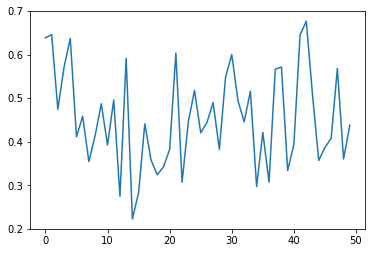

0.4533537128627793
______NOOKS_________
DAY 4


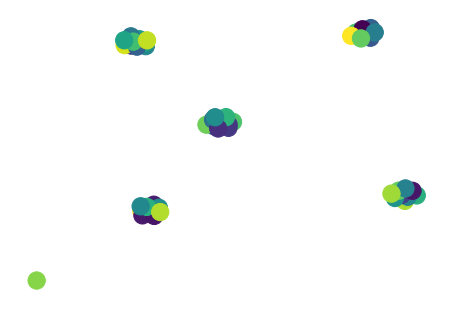

______NETWORK_________


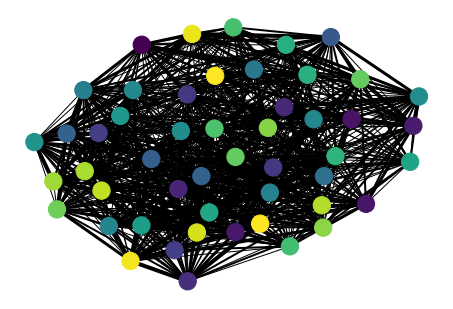

                        0         1
0    [0.9619107455346222]  0.638674
1   [0.06441444674001473]  0.598752
2    [0.7891942715303771]  0.545132
3     [0.177226238283531]  0.395603
4    [0.9440371060941252]  0.637144
5    [0.6091959154527136]  0.382626
6     [0.839591919659533]  0.561659
7    [0.4406367464203794]  0.330510
8    [0.6775089279258867]  0.414569
9   [0.17855500858877416]  0.543549
10  [0.28493851781217705]  0.322840
11  [0.11384921261232228]  0.425293
12   [0.5158618344686122]  0.256819
13   [0.9333196008170971]  0.585929
14  [0.44673635143702617]  0.223296
15   [0.7510065789639694]  0.283701
16  [0.07845944951476702]  0.441416
17     [0.57412693913227]  0.341216
18   [0.5326677331923972]  0.298561
19   [0.4687401068189414]  0.245869
20  [0.35736784515754816]  0.444901
21  [0.05295805297084666]  0.643763
22   [0.4960445674936236]  0.307269
23   [0.6919055562617197]  0.445151
24   [0.8994784804713435]  0.461432
25  [0.38438243606127953]  0.420871
26   [0.7318488841888736]  0

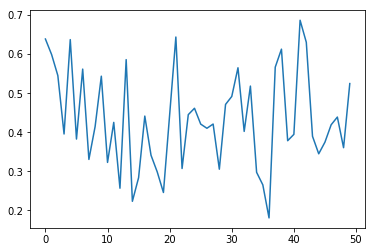

0.43294704845870313
______NOOKS_________
DAY 5


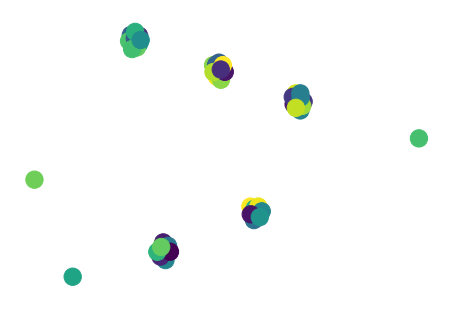

______NETWORK_________


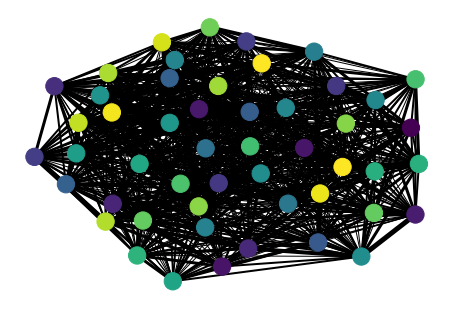

                        0         1
0    [0.9619107455346222]  0.625314
1   [0.06441444674001473]  0.611238
2    [0.7891942715303771]  0.545132
3     [0.177226238283531]  0.395603
4    [0.9440371060941252]  0.498612
5    [0.6091959154527136]  0.322674
6     [0.839591919659533]  0.521630
7    [0.4406367464203794]  0.318019
8    [0.6775089279258867]  0.229797
9   [0.17855500858877416]  0.543549
10  [0.28493851781217705]  0.388185
11  [0.11384921261232228]  0.536000
12   [0.5158618344686122]  0.256819
13   [0.9333196008170971]  0.697177
14  [0.44673635143702617]  0.284819
15   [0.7510065789639694]  0.283701
16  [0.07845944951476702]  0.441416
17     [0.57412693913227]  0.375434
18   [0.5326677331923972]  0.247473
19   [0.4687401068189414]  0.281741
20  [0.35736784515754816]  0.386558
21  [0.05295805297084666]  0.767363
22   [0.4960445674936236]  0.282800
23   [0.6919055562617197]  0.295459
24   [0.8994784804713435]  0.476783
25  [0.38438243606127953]  0.353938
26   [0.7318488841888736]  0

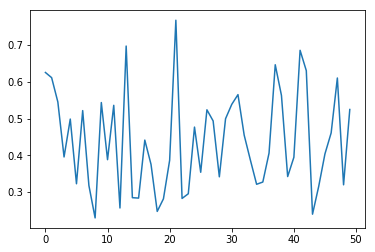

0.43926239866977546
______NOOKS_________
DAY 6


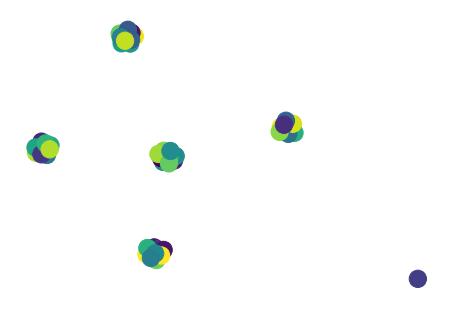

______NETWORK_________


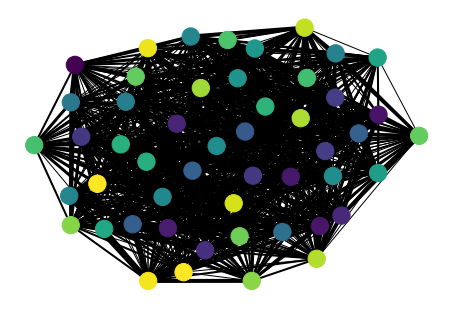

                        0         1
0    [0.9619107455346222]  0.638309
1   [0.06441444674001473]  0.541294
2    [0.7891942715303771]  0.540961
3     [0.177226238283531]  0.525653
4    [0.9440371060941252]  0.498612
5    [0.6091959154527136]  0.281969
6     [0.839591919659533]  0.397467
7    [0.4406367464203794]  0.318019
8    [0.6775089279258867]  0.340760
9   [0.17855500858877416]  0.543549
10  [0.28493851781217705]  0.388185
11  [0.11384921261232228]  0.456122
12   [0.5158618344686122]  0.308404
13   [0.9333196008170971]  0.697177
14  [0.44673635143702617]  0.294867
15   [0.7510065789639694]  0.327631
16  [0.07845944951476702]  0.579392
17     [0.57412693913227]  0.375434
18   [0.5326677331923972]  0.247473
19   [0.4687401068189414]  0.286320
20  [0.35736784515754816]  0.440262
21  [0.05295805297084666]  0.665625
22   [0.4960445674936236]  0.283066
23   [0.6919055562617197]  0.279368
24   [0.8994784804713435]  0.446408
25  [0.38438243606127953]  0.376477
26   [0.7318488841888736]  0

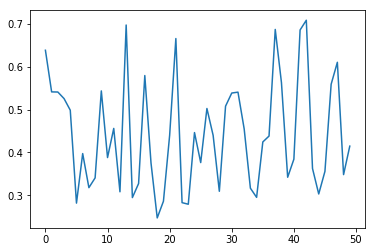

0.4434567045558574
______NOOKS_________
DAY 7


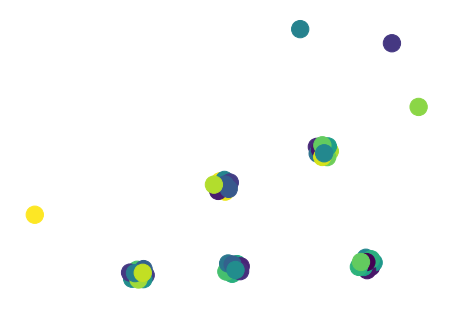

______NETWORK_________


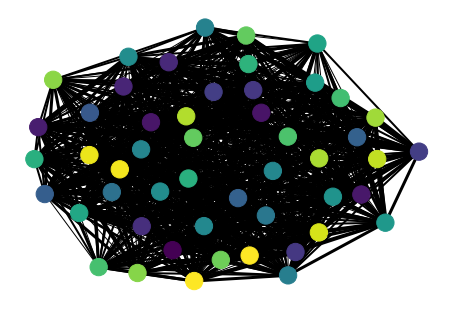

                        0         1
0    [0.9619107455346222]  0.638309
1   [0.06441444674001473]  0.639244
2    [0.7891942715303771]  0.542158
3     [0.177226238283531]  0.450408
4    [0.9440371060941252]  0.498612
5    [0.6091959154527136]  0.425078
6     [0.839591919659533]  0.248967
7    [0.4406367464203794]  0.318019
8    [0.6775089279258867]  0.426867
9   [0.17855500858877416]  0.556457
10  [0.28493851781217705]  0.298620
11  [0.11384921261232228]  0.456122
12   [0.5158618344686122]  0.320891
13   [0.9333196008170971]  0.812337
14  [0.44673635143702617]  0.294867
15   [0.7510065789639694]  0.381791
16  [0.07845944951476702]  0.625023
17     [0.57412693913227]  0.304524
18   [0.5326677331923972]  0.262523
19   [0.4687401068189414]  0.303923
20  [0.35736784515754816]  0.424295
21  [0.05295805297084666]  0.675123
22   [0.4960445674936236]  0.283066
23   [0.6919055562617197]  0.337671
24   [0.8994784804713435]  0.507290
25  [0.38438243606127953]  0.353938
26   [0.7318488841888736]  0

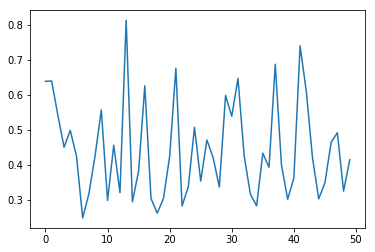

0.4423978187370509
______NOOKS_________
DAY 8


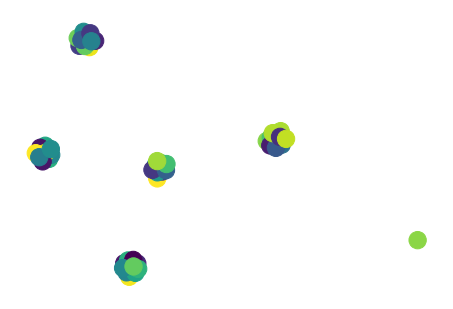

______NETWORK_________


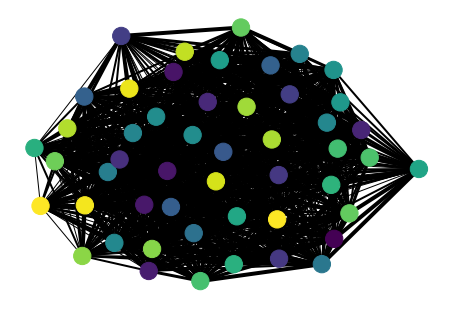

                        0         1
0    [0.9619107455346222]  0.584725
1   [0.06441444674001473]  0.639244
2    [0.7891942715303771]  0.542158
3     [0.177226238283531]  0.450408
4    [0.9440371060941252]  0.597933
5    [0.6091959154527136]  0.425078
6     [0.839591919659533]  0.558198
7    [0.4406367464203794]  0.318019
8    [0.6775089279258867]  0.342001
9   [0.17855500858877416]  0.556457
10  [0.28493851781217705]  0.332076
11  [0.11384921261232228]  0.511046
12   [0.5158618344686122]  0.221748
13   [0.9333196008170971]  0.793145
14  [0.44673635143702617]  0.294867
15   [0.7510065789639694]  0.287509
16  [0.07845944951476702]  0.579392
17     [0.57412693913227]  0.304524
18   [0.5326677331923972]  0.271397
19   [0.4687401068189414]  0.279991
20  [0.35736784515754816]  0.411158
21  [0.05295805297084666]  0.461422
22   [0.4960445674936236]  0.283066
23   [0.6919055562617197]  0.337671
24   [0.8994784804713435]  0.478769
25  [0.38438243606127953]  0.331601
26   [0.7318488841888736]  0

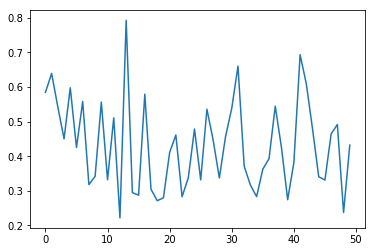

0.4320704416693505
______NOOKS_________
DAY 9


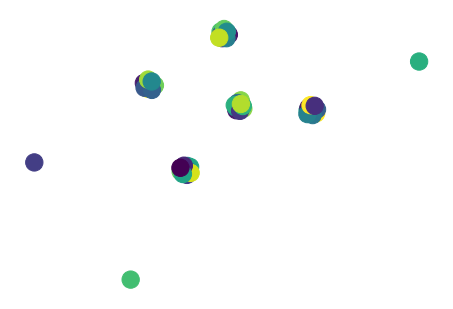

______NETWORK_________


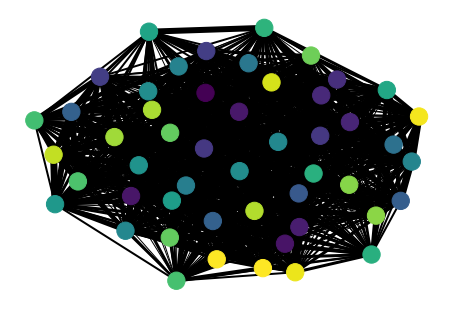

                        0         1
0    [0.9619107455346222]  0.505445
1   [0.06441444674001473]  0.496676
2    [0.7891942715303771]  0.497060
3     [0.177226238283531]  0.450408
4    [0.9440371060941252]  0.729199
5    [0.6091959154527136]  0.399161
6     [0.839591919659533]  0.459245
7    [0.4406367464203794]  0.318019
8    [0.6775089279258867]  0.356842
9   [0.17855500858877416]  0.401421
10  [0.28493851781217705]  0.360777
11  [0.11384921261232228]  0.680929
12   [0.5158618344686122]  0.310504
13   [0.9333196008170971]  0.684369
14  [0.44673635143702617]  0.337690
15   [0.7510065789639694]  0.287509
16  [0.07845944951476702]  0.579392
17     [0.57412693913227]  0.366317
18   [0.5326677331923972]  0.301022
19   [0.4687401068189414]  0.303923
20  [0.35736784515754816]  0.374072
21  [0.05295805297084666]  0.455704
22   [0.4960445674936236]  0.277855
23   [0.6919055562617197]  0.337671
24   [0.8994784804713435]  0.321442
25  [0.38438243606127953]  0.422421
26   [0.7318488841888736]  0

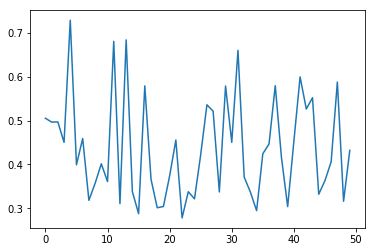

0.4368261652558902
______NOOKS_________
DAY 10


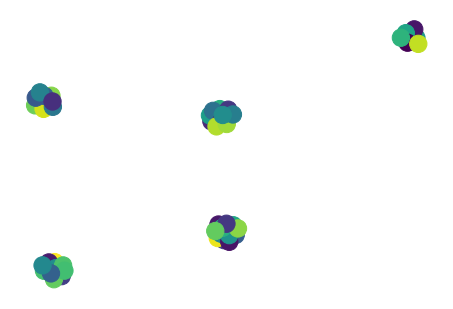

______NETWORK_________


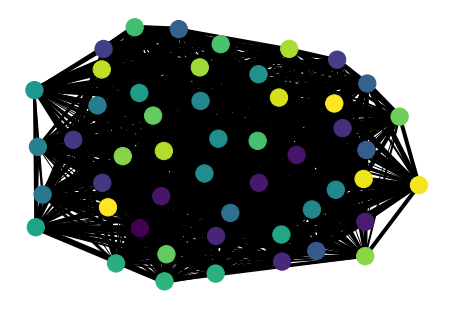

                        0         1
0    [0.9619107455346222]  0.505445
1   [0.06441444674001473]  0.639244
2    [0.7891942715303771]  0.426177
3     [0.177226238283531]  0.432082
4    [0.9440371060941252]  0.597933
5    [0.6091959154527136]  0.292808
6     [0.839591919659533]  0.333573
7    [0.4406367464203794]  0.318019
8    [0.6775089279258867]  0.389889
9   [0.17855500858877416]  0.492016
10  [0.28493851781217705]  0.360777
11  [0.11384921261232228]  0.680929
12   [0.5158618344686122]  0.310504
13   [0.9333196008170971]  0.773126
14  [0.44673635143702617]  0.337690
15   [0.7510065789639694]  0.363393
16  [0.07845944951476702]  0.475248
17     [0.57412693913227]  0.366317
18   [0.5326677331923972]  0.301022
19   [0.4687401068189414]  0.261635
20  [0.35736784515754816]  0.367981
21  [0.05295805297084666]  0.504408
22   [0.4960445674936236]  0.290065
23   [0.6919055562617197]  0.337671
24   [0.8994784804713435]  0.321442
25  [0.38438243606127953]  0.386557
26   [0.7318488841888736]  0

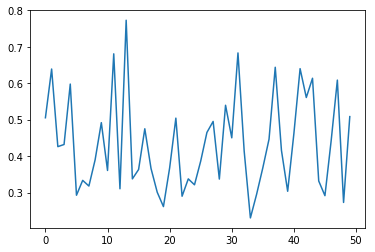

0.4337555483760716
______NOOKS_________
DAY 11


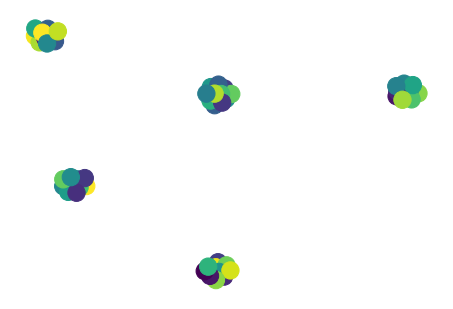

______NETWORK_________


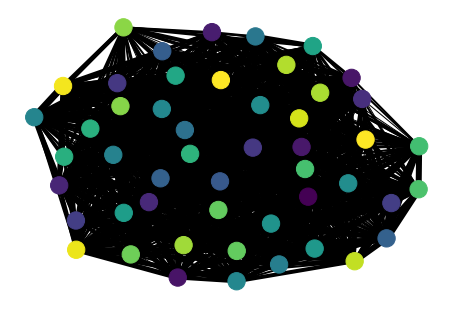

                        0         1
0    [0.9619107455346222]  0.559871
1   [0.06441444674001473]  0.660731
2    [0.7891942715303771]  0.426177
3     [0.177226238283531]  0.432082
4    [0.9440371060941252]  0.729199
5    [0.6091959154527136]  0.262176
6     [0.839591919659533]  0.437968
7    [0.4406367464203794]  0.318019
8    [0.6775089279258867]  0.389889
9   [0.17855500858877416]  0.538042
10  [0.28493851781217705]  0.372248
11  [0.11384921261232228]  0.569507
12   [0.5158618344686122]  0.310504
13   [0.9333196008170971]  0.593774
14  [0.44673635143702617]  0.269770
15   [0.7510065789639694]  0.322790
16  [0.07845944951476702]  0.475248
17     [0.57412693913227]  0.366317
18   [0.5326677331923972]  0.232356
19   [0.4687401068189414]  0.261635
20  [0.35736784515754816]  0.367981
21  [0.05295805297084666]  0.447748
22   [0.4960445674936236]  0.277855
23   [0.6919055562617197]  0.337671
24   [0.8994784804713435]  0.383011
25  [0.38438243606127953]  0.376477
26   [0.7318488841888736]  0

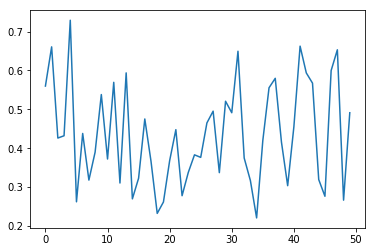

0.4350179089111608
______NOOKS_________
DAY 12


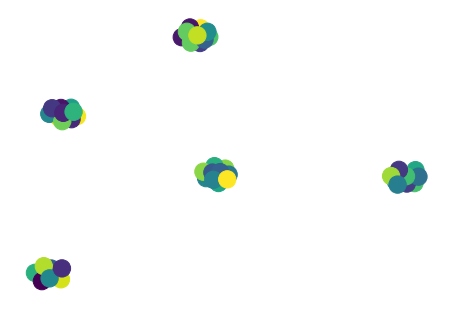

______NETWORK_________


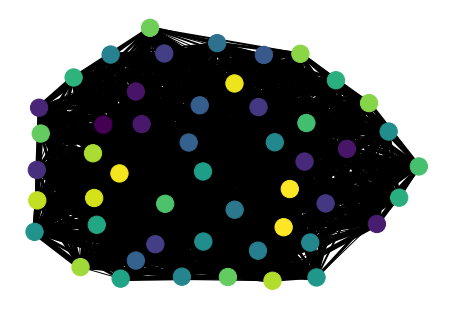

                        0         1
0    [0.9619107455346222]  0.559871
1   [0.06441444674001473]  0.592853
2    [0.7891942715303771]  0.426177
3     [0.177226238283531]  0.471254
4    [0.9440371060941252]  0.729199
5    [0.6091959154527136]  0.376235
6     [0.839591919659533]  0.437968
7    [0.4406367464203794]  0.318019
8    [0.6775089279258867]  0.337831
9   [0.17855500858877416]  0.463495
10  [0.28493851781217705]  0.360777
11  [0.11384921261232228]  0.494683
12   [0.5158618344686122]  0.310504
13   [0.9333196008170971]  0.644766
14  [0.44673635143702617]  0.269770
15   [0.7510065789639694]  0.309849
16  [0.07845944951476702]  0.487091
17     [0.57412693913227]  0.355612
18   [0.5326677331923972]  0.297443
19   [0.4687401068189414]  0.261635
20  [0.35736784515754816]  0.456247
21  [0.05295805297084666]  0.447748
22   [0.4960445674936236]  0.301812
23   [0.6919055562617197]  0.337671
24   [0.8994784804713435]  0.383011
25  [0.38438243606127953]  0.422421
26   [0.7318488841888736]  0

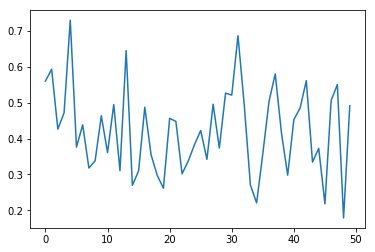

0.4218158630766822
______NOOKS_________
DAY 13


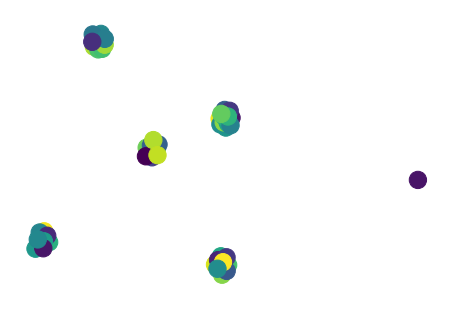

______NETWORK_________


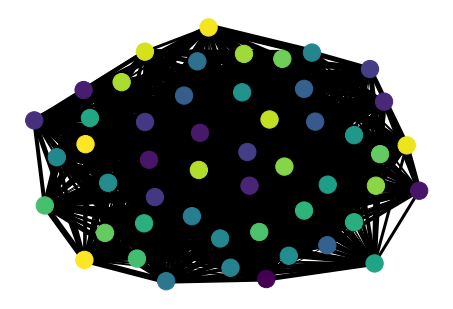

                        0         1
0    [0.9619107455346222]  0.655751
1   [0.06441444674001473]  0.592853
2    [0.7891942715303771]  0.440663
3     [0.177226238283531]  0.471254
4    [0.9440371060941252]  0.634768
5    [0.6091959154527136]  0.289480
6     [0.839591919659533]  0.405085
7    [0.4406367464203794]  0.318019
8    [0.6775089279258867]  0.420846
9   [0.17855500858877416]  0.492016
10  [0.28493851781217705]  0.360777
11  [0.11384921261232228]  0.609982
12   [0.5158618344686122]  0.306837
13   [0.9333196008170971]  0.716729
14  [0.44673635143702617]  0.269770
15   [0.7510065789639694]  0.333716
16  [0.07845944951476702]  0.475248
17     [0.57412693913227]  0.299197
18   [0.5326677331923972]  0.293356
19   [0.4687401068189414]  0.261635
20  [0.35736784515754816]  0.431716
21  [0.05295805297084666]  0.451580
22   [0.4960445674936236]  0.290065
23   [0.6919055562617197]  0.319283
24   [0.8994784804713435]  0.387668
25  [0.38438243606127953]  0.422421
26   [0.7318488841888736]  0

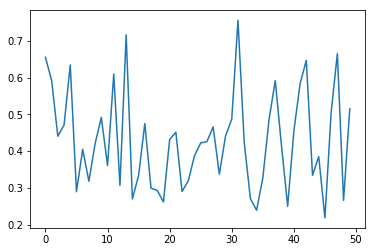

0.428954853596581
______NOOKS_________
DAY 14


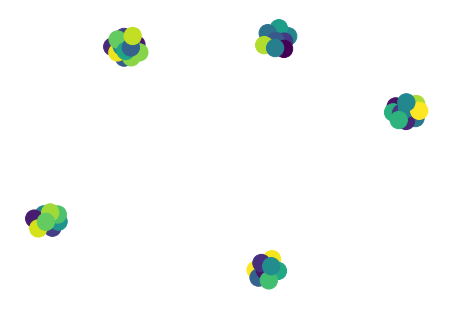

______NETWORK_________


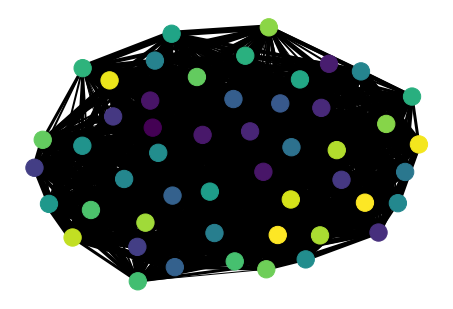

                        0         1
0    [0.9619107455346222]  0.676008
1   [0.06441444674001473]  0.592853
2    [0.7891942715303771]  0.361869
3     [0.177226238283531]  0.525255
4    [0.9440371060941252]  0.634768
5    [0.6091959154527136]  0.219083
6     [0.839591919659533]  0.405085
7    [0.4406367464203794]  0.318019
8    [0.6775089279258867]  0.426249
9   [0.17855500858877416]  0.578343
10  [0.28493851781217705]  0.360777
11  [0.11384921261232228]  0.591476
12   [0.5158618344686122]  0.207617
13   [0.9333196008170971]  0.753565
14  [0.44673635143702617]  0.269770
15   [0.7510065789639694]  0.333716
16  [0.07845944951476702]  0.475248
17     [0.57412693913227]  0.299197
18   [0.5326677331923972]  0.337284
19   [0.4687401068189414]  0.261635
20  [0.35736784515754816]  0.309259
21  [0.05295805297084666]  0.395058
22   [0.4960445674936236]  0.290065
23   [0.6919055562617197]  0.257382
24   [0.8994784804713435]  0.298614
25  [0.38438243606127953]  0.479305
26   [0.7318488841888736]  0

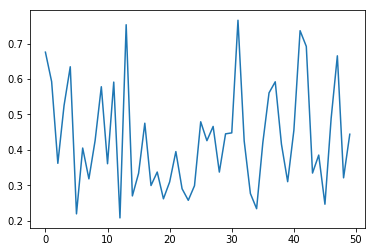

0.43100777363192044
______NOOKS_________
DAY 15


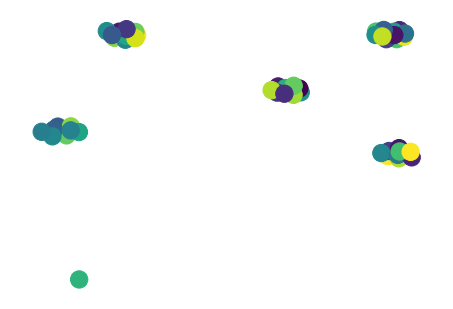

______NETWORK_________


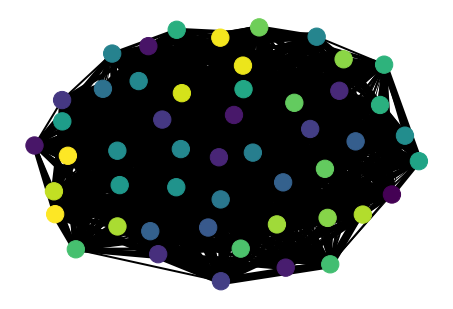

                        0         1
0    [0.9619107455346222]  0.588630
1   [0.06441444674001473]  0.657526
2    [0.7891942715303771]  0.435676
3     [0.177226238283531]  0.525255
4    [0.9440371060941252]  0.634768
5    [0.6091959154527136]  0.219083
6     [0.839591919659533]  0.405085
7    [0.4406367464203794]  0.321085
8    [0.6775089279258867]  0.420846
9   [0.17855500858877416]  0.578343
10  [0.28493851781217705]  0.360777
11  [0.11384921261232228]  0.591476
12   [0.5158618344686122]  0.296836
13   [0.9333196008170971]  0.753565
14  [0.44673635143702617]  0.269770
15   [0.7510065789639694]  0.333716
16  [0.07845944951476702]  0.475248
17     [0.57412693913227]  0.299197
18   [0.5326677331923972]  0.350022
19   [0.4687401068189414]  0.298123
20  [0.35736784515754816]  0.363234
21  [0.05295805297084666]  0.382419
22   [0.4960445674936236]  0.249397
23   [0.6919055562617197]  0.267140
24   [0.8994784804713435]  0.298614
25  [0.38438243606127953]  0.425781
26   [0.7318488841888736]  0

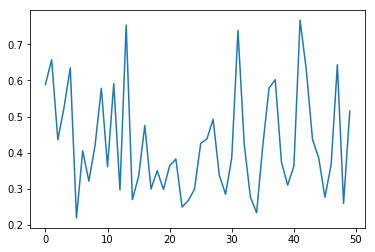

0.4268354903440018
______NOOKS_________
DAY 16


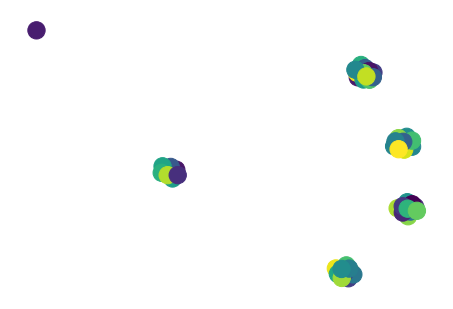

______NETWORK_________


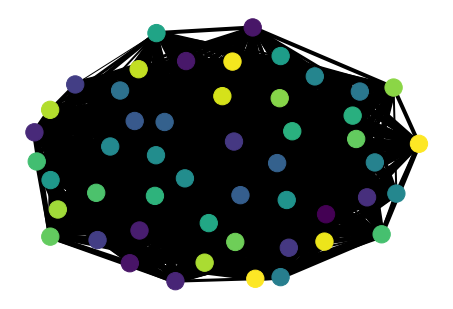

                        0         1
0    [0.9619107455346222]  0.655751
1   [0.06441444674001473]  0.657526
2    [0.7891942715303771]  0.570867
3     [0.177226238283531]  0.519554
4    [0.9440371060941252]  0.634768
5    [0.6091959154527136]  0.340222
6     [0.839591919659533]  0.405085
7    [0.4406367464203794]  0.253154
8    [0.6775089279258867]  0.447983
9   [0.17855500858877416]  0.578343
10  [0.28493851781217705]  0.419730
11  [0.11384921261232228]  0.527612
12   [0.5158618344686122]  0.232471
13   [0.9333196008170971]  0.778774
14  [0.44673635143702617]  0.214512
15   [0.7510065789639694]  0.412996
16  [0.07845944951476702]  0.579392
17     [0.57412693913227]  0.299197
18   [0.5326677331923972]  0.285156
19   [0.4687401068189414]  0.298123
20  [0.35736784515754816]  0.413180
21  [0.05295805297084666]  0.374431
22   [0.4960445674936236]  0.306858
23   [0.6919055562617197]  0.358857
24   [0.8994784804713435]  0.298614
25  [0.38438243606127953]  0.346357
26   [0.7318488841888736]  0

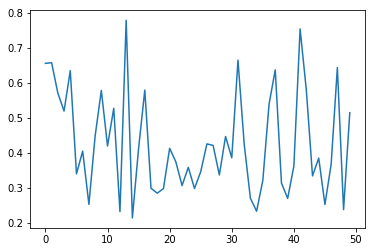

0.42675255040263754
______NOOKS_________
DAY 17


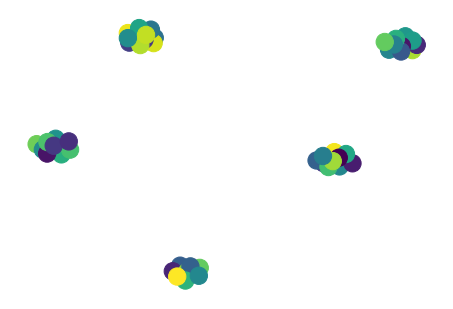

______NETWORK_________


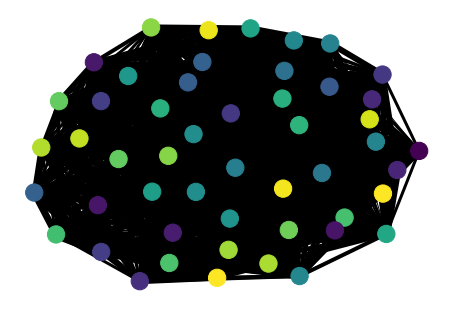

                        0         1
0    [0.9619107455346222]  0.676008
1   [0.06441444674001473]  0.500123
2    [0.7891942715303771]  0.570867
3     [0.177226238283531]  0.519554
4    [0.9440371060941252]  0.507337
5    [0.6091959154527136]  0.325831
6     [0.839591919659533]  0.529140
7    [0.4406367464203794]  0.253154
8    [0.6775089279258867]  0.289777
9   [0.17855500858877416]  0.531314
10  [0.28493851781217705]  0.419730
11  [0.11384921261232228]  0.586343
12   [0.5158618344686122]  0.207351
13   [0.9333196008170971]  0.778774
14  [0.44673635143702617]  0.272674
15   [0.7510065789639694]  0.422149
16  [0.07845944951476702]  0.600470
17     [0.57412693913227]  0.315391
18   [0.5326677331923972]  0.372672
19   [0.4687401068189414]  0.298123
20  [0.35736784515754816]  0.384211
21  [0.05295805297084666]  0.510325
22   [0.4960445674936236]  0.245607
23   [0.6919055562617197]  0.251852
24   [0.8994784804713435]  0.539612
25  [0.38438243606127953]  0.346357
26   [0.7318488841888736]  0

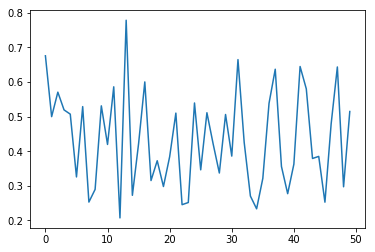

0.4336734429163749
______NOOKS_________
DAY 18


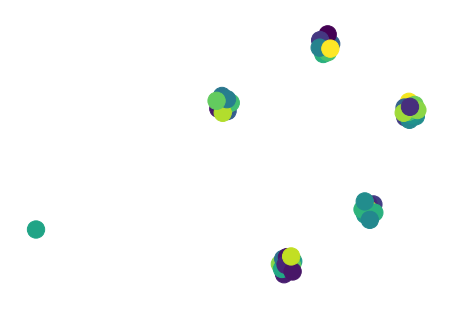

______NETWORK_________


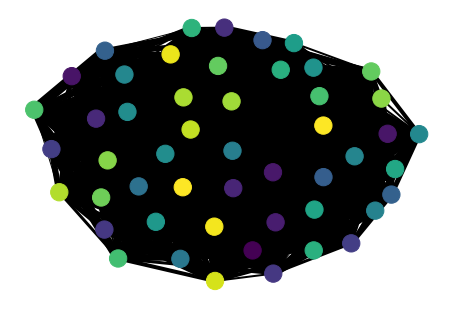

                        0         1
0    [0.9619107455346222]  0.676937
1   [0.06441444674001473]  0.542934
2    [0.7891942715303771]  0.627349
3     [0.177226238283531]  0.519554
4    [0.9440371060941252]  0.507337
5    [0.6091959154527136]  0.396531
6     [0.839591919659533]  0.638785
7    [0.4406367464203794]  0.326273
8    [0.6775089279258867]  0.379730
9   [0.17855500858877416]  0.531314
10  [0.28493851781217705]  0.419730
11  [0.11384921261232228]  0.639034
12   [0.5158618344686122]  0.207351
13   [0.9333196008170971]  0.750947
14  [0.44673635143702617]  0.272674
15   [0.7510065789639694]  0.428313
16  [0.07845944951476702]  0.650339
17     [0.57412693913227]  0.315391
18   [0.5326677331923972]  0.273707
19   [0.4687401068189414]  0.274191
20  [0.35736784515754816]  0.384914
21  [0.05295805297084666]  0.631233
22   [0.4960445674936236]  0.245607
23   [0.6919055562617197]  0.251852
24   [0.8994784804713435]  0.539612
25  [0.38438243606127953]  0.413291
26   [0.7318488841888736]  0

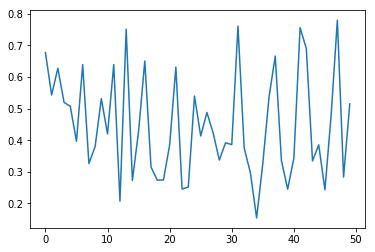

0.44751323852469027
______NOOKS_________
DAY 19


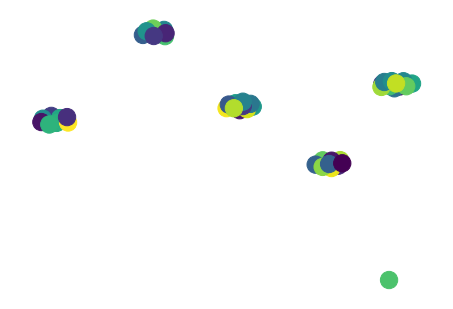

______NETWORK_________


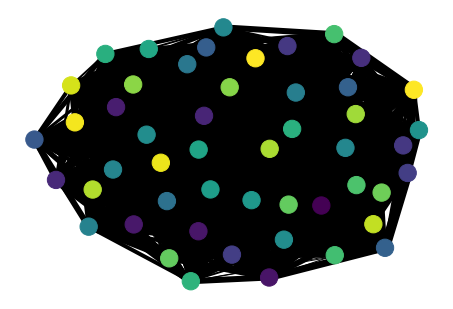

                        0         1
0    [0.9619107455346222]  0.676008
1   [0.06441444674001473]  0.500123
2    [0.7891942715303771]  0.627349
3     [0.177226238283531]  0.519554
4    [0.9440371060941252]  0.507337
5    [0.6091959154527136]  0.321992
6     [0.839591919659533]  0.638785
7    [0.4406367464203794]  0.326273
8    [0.6775089279258867]  0.397001
9   [0.17855500858877416]  0.643829
10  [0.28493851781217705]  0.419730
11  [0.11384921261232228]  0.626179
12   [0.5158618344686122]  0.207351
13   [0.9333196008170971]  0.750947
14  [0.44673635143702617]  0.272674
15   [0.7510065789639694]  0.412996
16  [0.07845944951476702]  0.600470
17     [0.57412693913227]  0.315391
18   [0.5326677331923972]  0.273707
19   [0.4687401068189414]  0.240768
20  [0.35736784515754816]  0.384914
21  [0.05295805297084666]  0.428853
22   [0.4960445674936236]  0.245607
23   [0.6919055562617197]  0.353327
24   [0.8994784804713435]  0.539612
25  [0.38438243606127953]  0.390751
26   [0.7318488841888736]  0

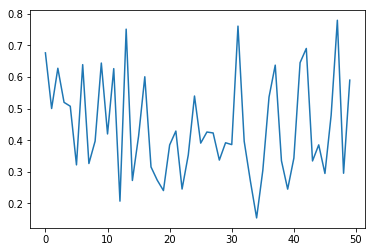

0.4412474463347127
______NOOKS_________
DAY 20


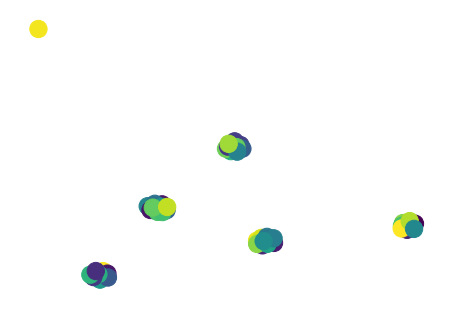

______NETWORK_________


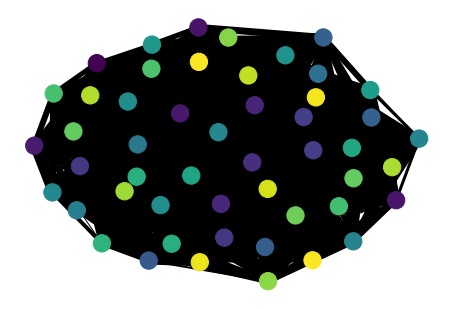

                        0         1
0    [0.9619107455346222]  0.676008
1   [0.06441444674001473]  0.599059
2    [0.7891942715303771]  0.438434
3     [0.177226238283531]  0.519554
4    [0.9440371060941252]  0.521012
5    [0.6091959154527136]  0.205658
6     [0.839591919659533]  0.580196
7    [0.4406367464203794]  0.326273
8    [0.6775089279258867]  0.301542
9   [0.17855500858877416]  0.592837
10  [0.28493851781217705]  0.432695
11  [0.11384921261232228]  0.626179
12   [0.5158618344686122]  0.280319
13   [0.9333196008170971]  0.716873
14  [0.44673635143702617]  0.214512
15   [0.7510065789639694]  0.395635
16  [0.07845944951476702]  0.600470
17     [0.57412693913227]  0.315391
18   [0.5326677331923972]  0.287493
19   [0.4687401068189414]  0.240768
20  [0.35736784515754816]  0.384211
21  [0.05295805297084666]  0.536900
22   [0.4960445674936236]  0.245607
23   [0.6919055562617197]  0.353327
24   [0.8994784804713435]  0.539612
25  [0.38438243606127953]  0.390751
26   [0.7318488841888736]  0

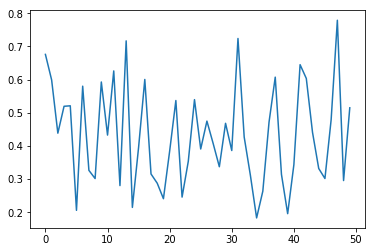

0.43255180606941485
______NOOKS_________
DAY 21


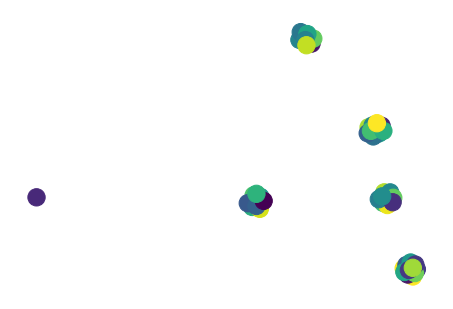

______NETWORK_________


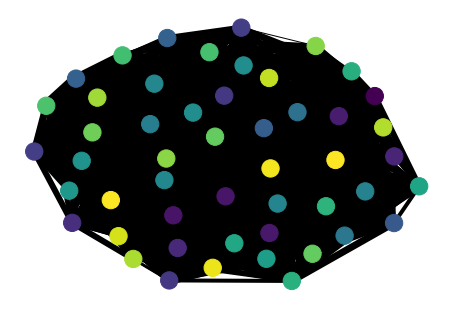

                        0         1
0    [0.9619107455346222]  0.676008
1   [0.06441444674001473]  0.599059
2    [0.7891942715303771]  0.367552
3     [0.177226238283531]  0.519554
4    [0.9440371060941252]  0.521012
5    [0.6091959154527136]  0.205658
6     [0.839591919659533]  0.495926
7    [0.4406367464203794]  0.326273
8    [0.6775089279258867]  0.257629
9   [0.17855500858877416]  0.566523
10  [0.28493851781217705]  0.502000
11  [0.11384921261232228]  0.514758
12   [0.5158618344686122]  0.281681
13   [0.9333196008170971]  0.581469
14  [0.44673635143702617]  0.214512
15   [0.7510065789639694]  0.407126
16  [0.07845944951476702]  0.600470
17     [0.57412693913227]  0.315391
18   [0.5326677331923972]  0.287493
19   [0.4687401068189414]  0.240768
20  [0.35736784515754816]  0.384211
21  [0.05295805297084666]  0.589935
22   [0.4960445674936236]  0.224805
23   [0.6919055562617197]  0.353327
24   [0.8994784804713435]  0.539612
25  [0.38438243606127953]  0.390751
26   [0.7318488841888736]  0

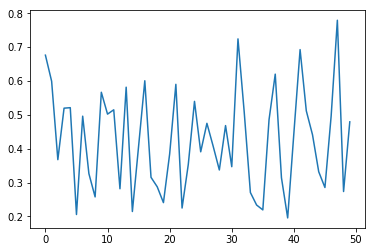

0.42612378007911483
______NOOKS_________
DAY 22


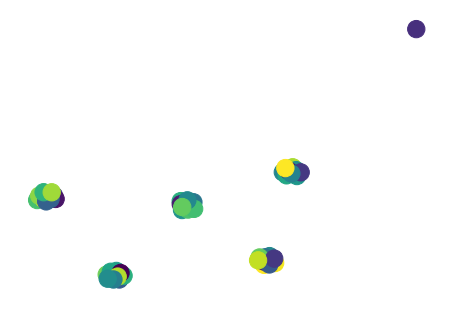

______NETWORK_________


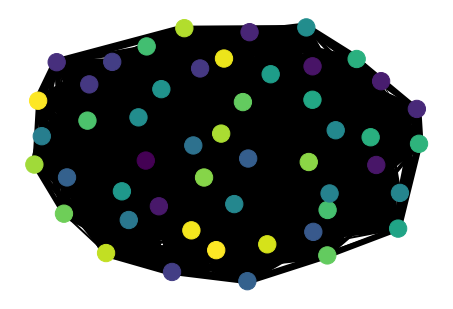

                        0         1
0    [0.9619107455346222]  0.655751
1   [0.06441444674001473]  0.600392
2    [0.7891942715303771]  0.492438
3     [0.177226238283531]  0.519554
4    [0.9440371060941252]  0.521012
5    [0.6091959154527136]  0.375226
6     [0.839591919659533]  0.495926
7    [0.4406367464203794]  0.326273
8    [0.6775089279258867]  0.414827
9   [0.17855500858877416]  0.578343
10  [0.28493851781217705]  0.419730
11  [0.11384921261232228]  0.543905
12   [0.5158618344686122]  0.257491
13   [0.9333196008170971]  0.581469
14  [0.44673635143702617]  0.235958
15   [0.7510065789639694]  0.391702
16  [0.07845944951476702]  0.621146
17     [0.57412693913227]  0.315391
18   [0.5326677331923972]  0.285463
19   [0.4687401068189414]  0.254437
20  [0.35736784515754816]  0.384211
21  [0.05295805297084666]  0.485821
22   [0.4960445674936236]  0.224805
23   [0.6919055562617197]  0.258006
24   [0.8994784804713435]  0.489472
25  [0.38438243606127953]  0.390751
26   [0.7318488841888736]  0

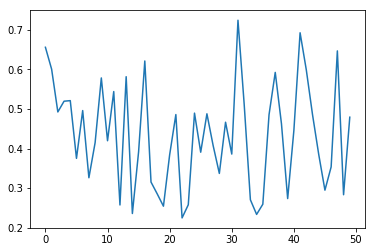

0.4336749527648586
______NOOKS_________
DAY 23


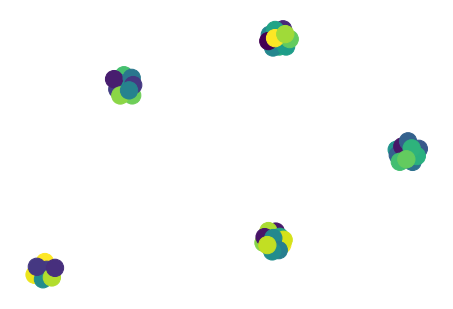

______NETWORK_________


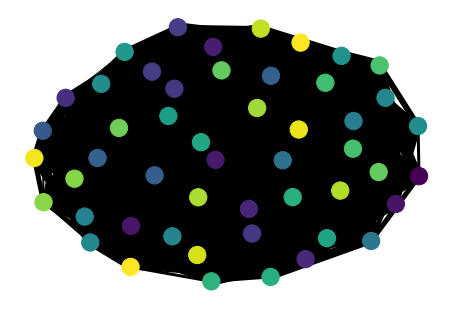

                        0         1
0    [0.9619107455346222]  0.668815
1   [0.06441444674001473]  0.600392
2    [0.7891942715303771]  0.492438
3     [0.177226238283531]  0.519554
4    [0.9440371060941252]  0.581342
5    [0.6091959154527136]  0.198990
6     [0.839591919659533]  0.495926
7    [0.4406367464203794]  0.265644
8    [0.6775089279258867]  0.414827
9   [0.17855500858877416]  0.578343
10  [0.28493851781217705]  0.419730
11  [0.11384921261232228]  0.485174
12   [0.5158618344686122]  0.257491
13   [0.9333196008170971]  0.711773
14  [0.44673635143702617]  0.235958
15   [0.7510065789639694]  0.430913
16  [0.07845944951476702]  0.672308
17     [0.57412693913227]  0.315391
18   [0.5326677331923972]  0.339811
19   [0.4687401068189414]  0.277000
20  [0.35736784515754816]  0.360184
21  [0.05295805297084666]  0.536900
22   [0.4960445674936236]  0.224805
23   [0.6919055562617197]  0.353327
24   [0.8994784804713435]  0.517994
25  [0.38438243606127953]  0.263698
26   [0.7318488841888736]  0

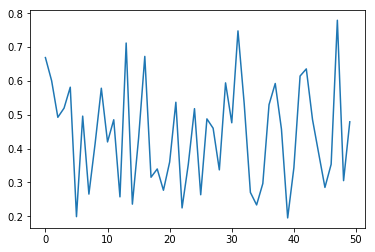

0.44195003520337633
______NOOKS_________
DAY 24


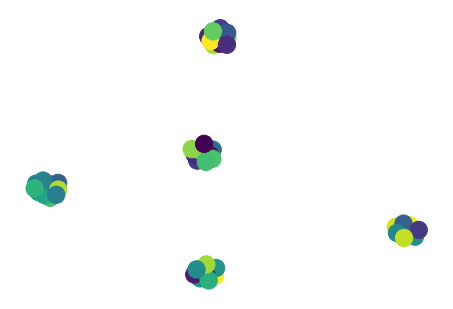

______NETWORK_________


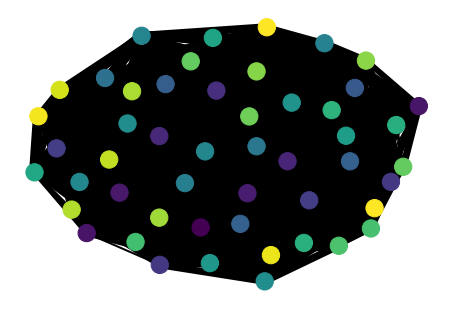

                        0         1
0    [0.9619107455346222]  0.668815
1   [0.06441444674001473]  0.714610
2    [0.7891942715303771]  0.501069
3     [0.177226238283531]  0.519554
4    [0.9440371060941252]  0.581342
5    [0.6091959154527136]  0.307961
6     [0.839591919659533]  0.552408
7    [0.4406367464203794]  0.265644
8    [0.6775089279258867]  0.324874
9   [0.17855500858877416]  0.535146
10  [0.28493851781217705]  0.419730
11  [0.11384921261232228]  0.485174
12   [0.5158618344686122]  0.257491
13   [0.9333196008170971]  0.711773
14  [0.44673635143702617]  0.235958
15   [0.7510065789639694]  0.430913
16  [0.07845944951476702]  0.672308
17     [0.57412693913227]  0.299197
18   [0.5326677331923972]  0.339811
19   [0.4687401068189414]  0.277000
20  [0.35736784515754816]  0.336498
21  [0.05295805297084666]  0.536900
22   [0.4960445674936236]  0.224805
23   [0.6919055562617197]  0.258006
24   [0.8994784804713435]  0.517994
25  [0.38438243606127953]  0.263698
26   [0.7318488841888736]  0

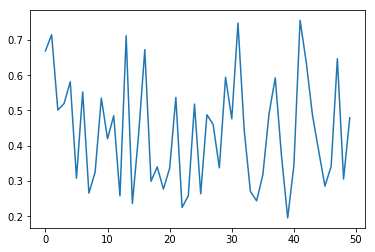

0.43863960087047377
______NOOKS_________
DAY 25


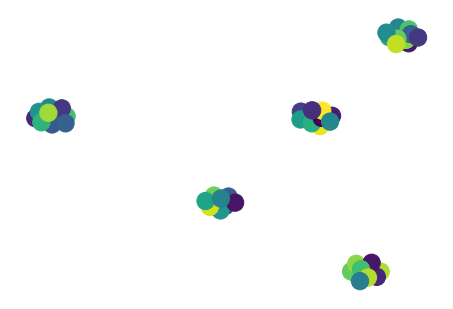

______NETWORK_________


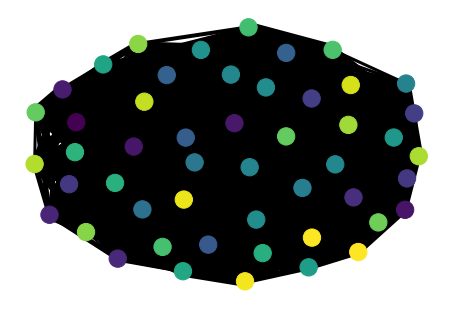

                        0         1
0    [0.9619107455346222]  0.668815
1   [0.06441444674001473]  0.600500
2    [0.7891942715303771]  0.534261
3     [0.177226238283531]  0.519554
4    [0.9440371060941252]  0.581342
5    [0.6091959154527136]  0.275602
6     [0.839591919659533]  0.552408
7    [0.4406367464203794]  0.265644
8    [0.6775089279258867]  0.352010
9   [0.17855500858877416]  0.535146
10  [0.28493851781217705]  0.419730
11  [0.11384921261232228]  0.485174
12   [0.5158618344686122]  0.272043
13   [0.9333196008170971]  0.711773
14  [0.44673635143702617]  0.179694
15   [0.7510065789639694]  0.431021
16  [0.07845944951476702]  0.616736
17     [0.57412693913227]  0.315391
18   [0.5326677331923972]  0.412811
19   [0.4687401068189414]  0.277000
20  [0.35736784515754816]  0.387803
21  [0.05295805297084666]  0.536900
22   [0.4960445674936236]  0.224805
23   [0.6919055562617197]  0.258006
24   [0.8994784804713435]  0.517994
25  [0.38438243606127953]  0.263698
26   [0.7318488841888736]  0

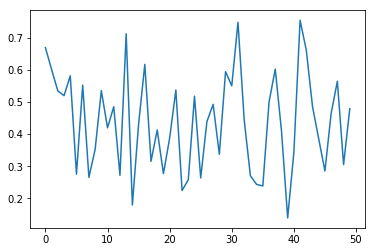

0.4386868910390224
______NOOKS_________
DAY 26


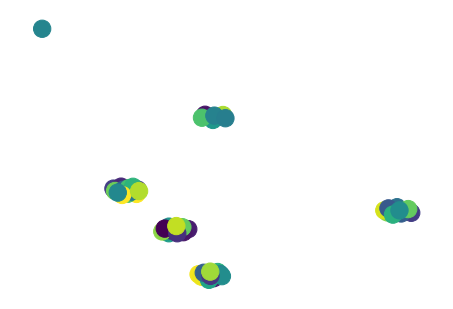

______NETWORK_________


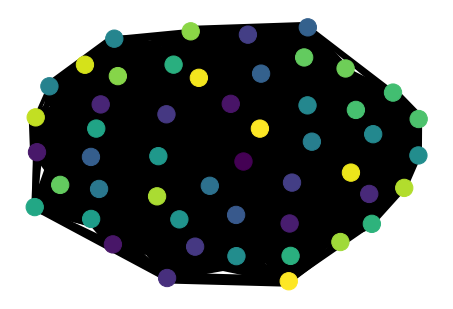

                        0         1
0    [0.9619107455346222]  0.668815
1   [0.06441444674001473]  0.566601
2    [0.7891942715303771]  0.615057
3     [0.177226238283531]  0.519554
4    [0.9440371060941252]  0.611608
5    [0.6091959154527136]  0.297519
6     [0.839591919659533]  0.552408
7    [0.4406367464203794]  0.265644
8    [0.6775089279258867]  0.352010
9   [0.17855500858877416]  0.570090
10  [0.28493851781217705]  0.419730
11  [0.11384921261232228]  0.572066
12   [0.5158618344686122]  0.272043
13   [0.9333196008170971]  0.711773
14  [0.44673635143702617]  0.179694
15   [0.7510065789639694]  0.431021
16  [0.07845944951476702]  0.666606
17     [0.57412693913227]  0.315391
18   [0.5326677331923972]  0.385828
19   [0.4687401068189414]  0.277000
20  [0.35736784515754816]  0.361981
21  [0.05295805297084666]  0.536900
22   [0.4960445674936236]  0.224805
23   [0.6919055562617197]  0.258006
24   [0.8994784804713435]  0.423886
25  [0.38438243606127953]  0.263698
26   [0.7318488841888736]  0

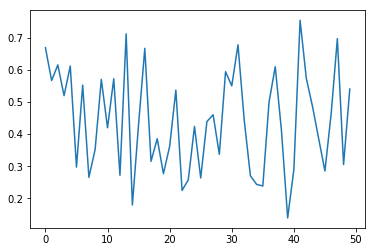

0.44030328982777045
______NOOKS_________
DAY 27


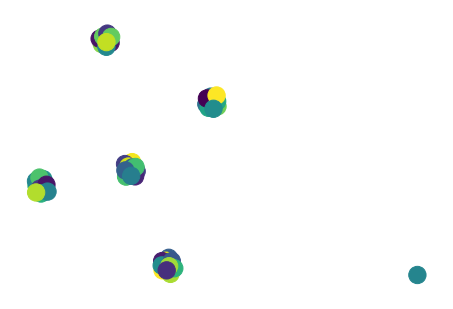

______NETWORK_________


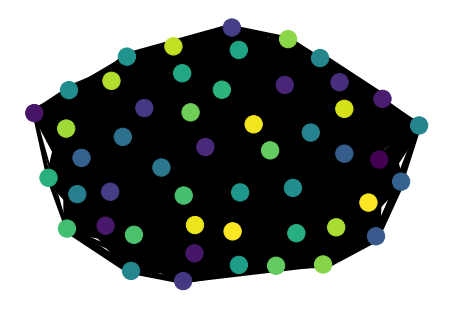

                        0         1
0    [0.9619107455346222]  0.668815
1   [0.06441444674001473]  0.566601
2    [0.7891942715303771]  0.615057
3     [0.177226238283531]  0.519554
4    [0.9440371060941252]  0.491318
5    [0.6091959154527136]  0.275602
6     [0.839591919659533]  0.552408
7    [0.4406367464203794]  0.265644
8    [0.6775089279258867]  0.324874
9   [0.17855500858877416]  0.605298
10  [0.28493851781217705]  0.502000
11  [0.11384921261232228]  0.543336
12   [0.5158618344686122]  0.296232
13   [0.9333196008170971]  0.745846
14  [0.44673635143702617]  0.216409
15   [0.7510065789639694]  0.387342
16  [0.07845944951476702]  0.666606
17     [0.57412693913227]  0.299197
18   [0.5326677331923972]  0.341901
19   [0.4687401068189414]  0.277000
20  [0.35736784515754816]  0.361981
21  [0.05295805297084666]  0.514277
22   [0.4960445674936236]  0.259925
23   [0.6919055562617197]  0.258006
24   [0.8994784804713435]  0.423886
25  [0.38438243606127953]  0.293264
26   [0.7318488841888736]  0

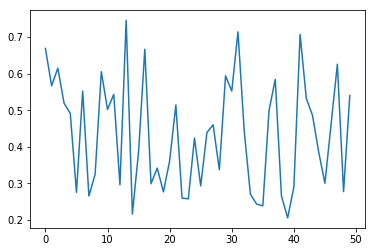

0.43460863979595254
______NOOKS_________
DAY 28


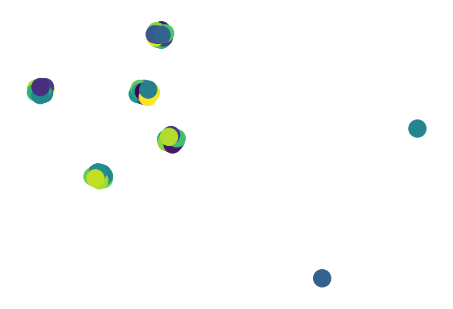

______NETWORK_________


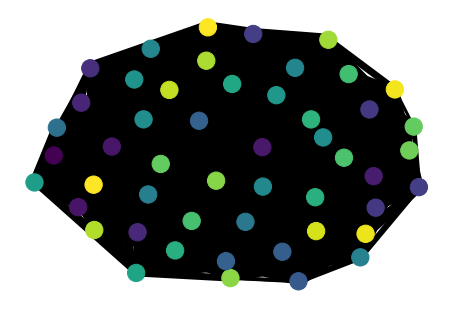

                        0         1
0    [0.9619107455346222]  0.668815
1   [0.06441444674001473]  0.566601
2    [0.7891942715303771]  0.551029
3     [0.177226238283531]  0.519554
4    [0.9440371060941252]  0.578724
5    [0.6091959154527136]  0.297519
6     [0.839591919659533]  0.552408
7    [0.4406367464203794]  0.265644
8    [0.6775089279258867]  0.364795
9   [0.17855500858877416]  0.605298
10  [0.28493851781217705]  0.419730
11  [0.11384921261232228]  0.543336
12   [0.5158618344686122]  0.296232
13   [0.9333196008170971]  0.745846
14  [0.44673635143702617]  0.274638
15   [0.7510065789639694]  0.387342
16  [0.07845944951476702]  0.637413
17     [0.57412693913227]  0.299197
18   [0.5326677331923972]  0.341901
19   [0.4687401068189414]  0.300932
20  [0.35736784515754816]  0.398226
21  [0.05295805297084666]  0.488196
22   [0.4960445674936236]  0.259925
23   [0.6919055562617197]  0.353061
24   [0.8994784804713435]  0.423886
25  [0.38438243606127953]  0.293264
26   [0.7318488841888736]  0

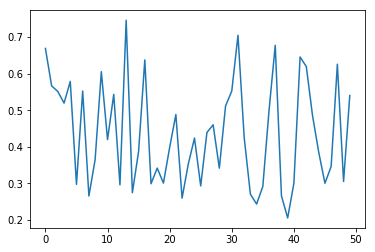

0.43754974353163256
______NOOKS_________
DAY 29


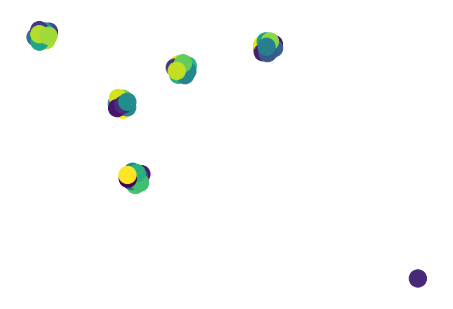

______NETWORK_________


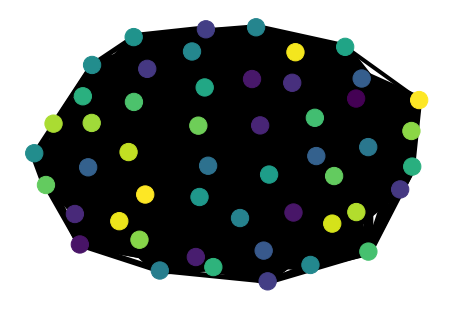

                        0         1
0    [0.9619107455346222]  0.668815
1   [0.06441444674001473]  0.600500
2    [0.7891942715303771]  0.551029
3     [0.177226238283531]  0.519554
4    [0.9440371060941252]  0.636818
5    [0.6091959154527136]  0.266594
6     [0.839591919659533]  0.605987
7    [0.4406367464203794]  0.265644
8    [0.6775089279258867]  0.333549
9   [0.17855500858877416]  0.605298
10  [0.28493851781217705]  0.419730
11  [0.11384921261232228]  0.567364
12   [0.5158618344686122]  0.296232
13   [0.9333196008170971]  0.674937
14  [0.44673635143702617]  0.274638
15   [0.7510065789639694]  0.429529
16  [0.07845944951476702]  0.637413
17     [0.57412693913227]  0.299197
18   [0.5326677331923972]  0.341901
19   [0.4687401068189414]  0.277000
20  [0.35736784515754816]  0.398226
21  [0.05295805297084666]  0.488196
22   [0.4960445674936236]  0.259925
23   [0.6919055562617197]  0.353061
24   [0.8994784804713435]  0.423886
25  [0.38438243606127953]  0.370825
26   [0.7318488841888736]  0

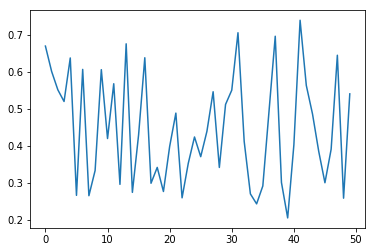

0.4456551202726585
______NOOKS_________
DAY 30


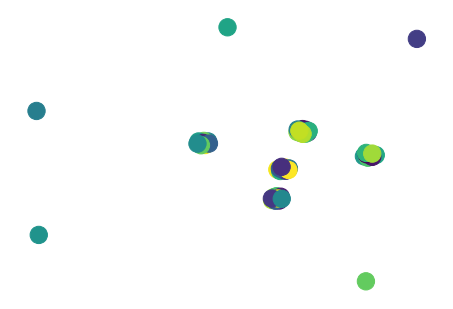

______NETWORK_________


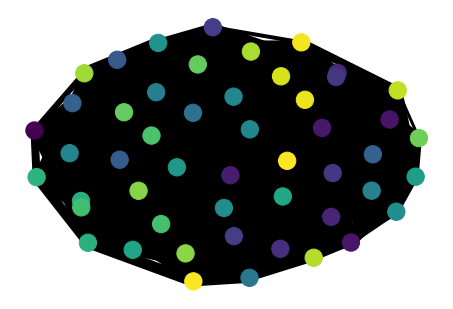

                        0         1
0    [0.9619107455346222]  0.668815
1   [0.06441444674001473]  0.578443
2    [0.7891942715303771]  0.551029
3     [0.177226238283531]  0.519554
4    [0.9440371060941252]  0.669865
5    [0.6091959154527136]  0.289510
6     [0.839591919659533]  0.552408
7    [0.4406367464203794]  0.265644
8    [0.6775089279258867]  0.380392
9   [0.17855500858877416]  0.605298
10  [0.28493851781217705]  0.345748
11  [0.11384921261232228]  0.567364
12   [0.5158618344686122]  0.296232
13   [0.9333196008170971]  0.674937
14  [0.44673635143702617]  0.274638
15   [0.7510065789639694]  0.429529
16  [0.07845944951476702]  0.637413
17     [0.57412693913227]  0.315391
18   [0.5326677331923972]  0.382040
19   [0.4687401068189414]  0.277000
20  [0.35736784515754816]  0.362939
21  [0.05295805297084666]  0.488196
22   [0.4960445674936236]  0.259925
23   [0.6919055562617197]  0.353327
24   [0.8994784804713435]  0.423886
25  [0.38438243606127953]  0.370825
26   [0.7318488841888736]  0

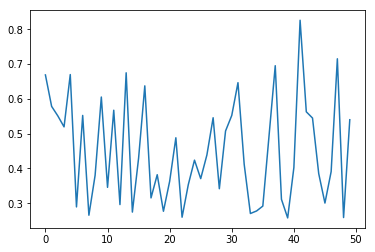

0.4502345468902518
______NOOKS_________
DAY 31


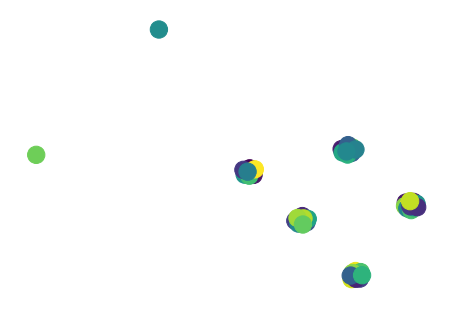

______NETWORK_________


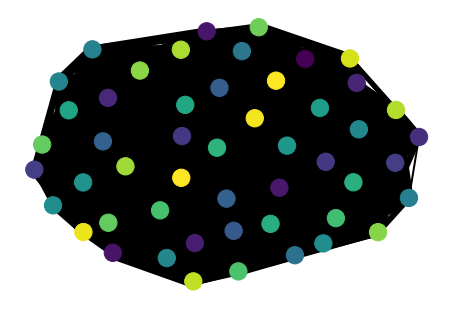

                        0         1
0    [0.9619107455346222]  0.668815
1   [0.06441444674001473]  0.578443
2    [0.7891942715303771]  0.539537
3     [0.177226238283531]  0.519554
4    [0.9440371060941252]  0.636818
5    [0.6091959154527136]  0.277462
6     [0.839591919659533]  0.605987
7    [0.4406367464203794]  0.265644
8    [0.6775089279258867]  0.322299
9   [0.17855500858877416]  0.605298
10  [0.28493851781217705]  0.379460
11  [0.11384921261232228]  0.487233
12   [0.5158618344686122]  0.345781
13   [0.9333196008170971]  0.674937
14  [0.44673635143702617]  0.323776
15   [0.7510065789639694]  0.457801
16  [0.07845944951476702]  0.637413
17     [0.57412693913227]  0.293818
18   [0.5326677331923972]  0.385828
19   [0.4687401068189414]  0.278369
20  [0.35736784515754816]  0.330923
21  [0.05295805297084666]  0.488196
22   [0.4960445674936236]  0.236553
23   [0.6919055562617197]  0.353327
24   [0.8994784804713435]  0.517994
25  [0.38438243606127953]  0.370825
26   [0.7318488841888736]  0

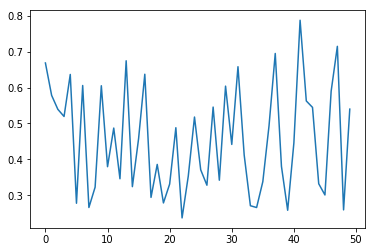

0.45386365403170686
______NOOKS_________
DAY 32


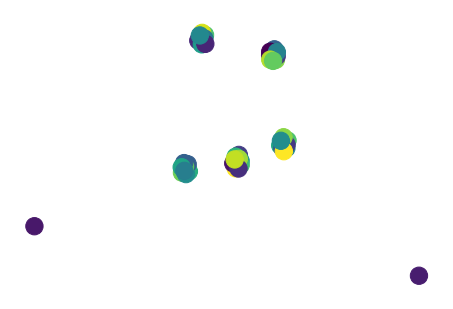

______NETWORK_________


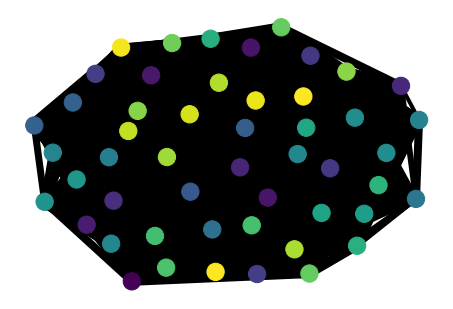

                        0         1
0    [0.9619107455346222]  0.668815
1   [0.06441444674001473]  0.578443
2    [0.7891942715303771]  0.539537
3     [0.177226238283531]  0.519554
4    [0.9440371060941252]  0.669865
5    [0.6091959154527136]  0.245896
6     [0.839591919659533]  0.605987
7    [0.4406367464203794]  0.265644
8    [0.6775089279258867]  0.333549
9   [0.17855500858877416]  0.494844
10  [0.28493851781217705]  0.428018
11  [0.11384921261232228]  0.487233
12   [0.5158618344686122]  0.345781
13   [0.9333196008170971]  0.674937
14  [0.44673635143702617]  0.225137
15   [0.7510065789639694]  0.506815
16  [0.07845944951476702]  0.637413
17     [0.57412693913227]  0.293818
18   [0.5326677331923972]  0.385828
19   [0.4687401068189414]  0.278369
20  [0.35736784515754816]  0.330923
21  [0.05295805297084666]  0.488196
22   [0.4960445674936236]  0.224805
23   [0.6919055562617197]  0.258006
24   [0.8994784804713435]  0.517994
25  [0.38438243606127953]  0.370825
26   [0.7318488841888736]  0

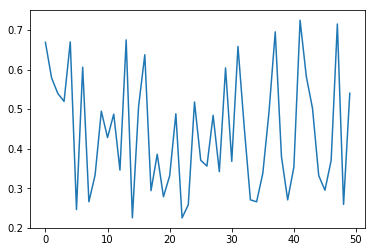

0.4406354642054379
______NOOKS_________
DAY 33


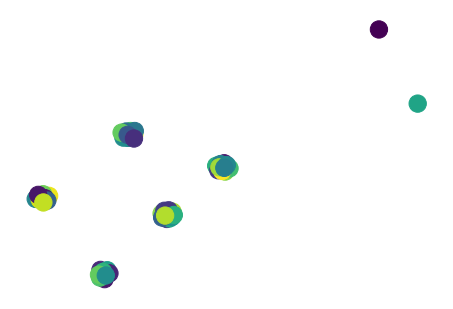

______NETWORK_________


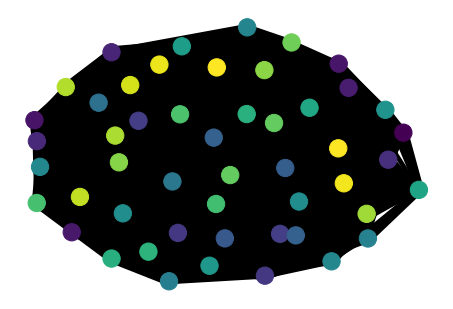

                        0         1
0    [0.9619107455346222]  0.701905
1   [0.06441444674001473]  0.578443
2    [0.7891942715303771]  0.539537
3     [0.177226238283531]  0.519554
4    [0.9440371060941252]  0.669865
5    [0.6091959154527136]  0.245896
6     [0.839591919659533]  0.605987
7    [0.4406367464203794]  0.326273
8    [0.6775089279258867]  0.361376
9   [0.17855500858877416]  0.494844
10  [0.28493851781217705]  0.457899
11  [0.11384921261232228]  0.410515
12   [0.5158618344686122]  0.321054
13   [0.9333196008170971]  0.674937
14  [0.44673635143702617]  0.283525
15   [0.7510065789639694]  0.531917
16  [0.07845944951476702]  0.637413
17     [0.57412693913227]  0.293818
18   [0.5326677331923972]  0.385828
19   [0.4687401068189414]  0.296716
20  [0.35736784515754816]  0.330923
21  [0.05295805297084666]  0.488196
22   [0.4960445674936236]  0.257196
23   [0.6919055562617197]  0.258006
24   [0.8994784804713435]  0.517994
25  [0.38438243606127953]  0.370825
26   [0.7318488841888736]  0

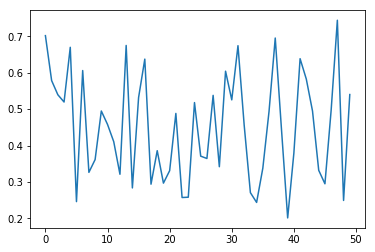

0.45008916272041655
______NOOKS_________
DAY 34


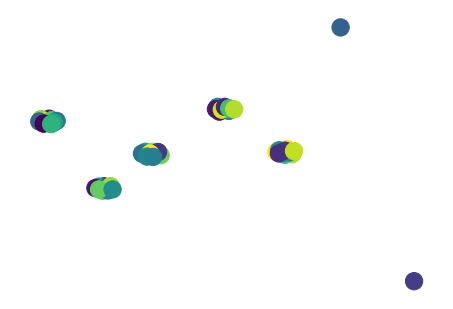

______NETWORK_________


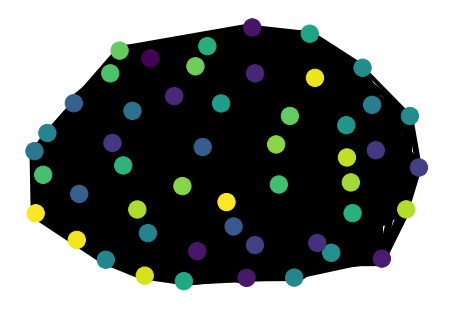

                        0         1
0    [0.9619107455346222]  0.701905
1   [0.06441444674001473]  0.692553
2    [0.7891942715303771]  0.551029
3     [0.177226238283531]  0.519554
4    [0.9440371060941252]  0.669865
5    [0.6091959154527136]  0.245896
6     [0.839591919659533]  0.605987
7    [0.4406367464203794]  0.265644
8    [0.6775089279258867]  0.361376
9   [0.17855500858877416]  0.494844
10  [0.28493851781217705]  0.345748
11  [0.11384921261232228]  0.410515
12   [0.5158618344686122]  0.321054
13   [0.9333196008170971]  0.674937
14  [0.44673635143702617]  0.318053
15   [0.7510065789639694]  0.440716
16  [0.07845944951476702]  0.637413
17     [0.57412693913227]  0.293818
18   [0.5326677331923972]  0.385828
19   [0.4687401068189414]  0.314694
20  [0.35736784515754816]  0.350727
21  [0.05295805297084666]  0.500017
22   [0.4960445674936236]  0.262416
23   [0.6919055562617197]  0.292445
24   [0.8994784804713435]  0.510041
25  [0.38438243606127953]  0.370825
26   [0.7318488841888736]  0

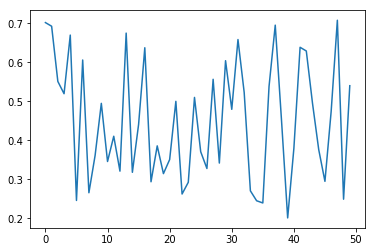

0.4491227871686813
______NOOKS_________
DAY 35


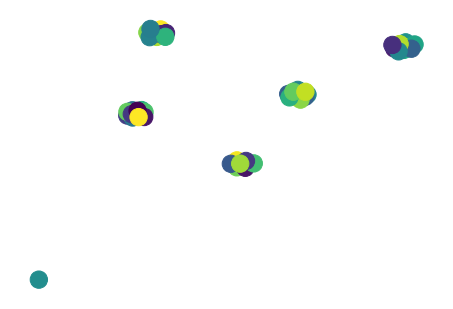

______NETWORK_________


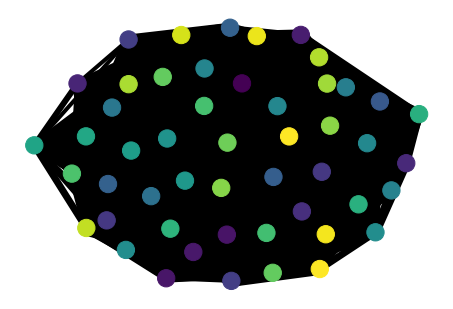

                        0         1
0    [0.9619107455346222]  0.701905
1   [0.06441444674001473]  0.692553
2    [0.7891942715303771]  0.551029
3     [0.177226238283531]  0.519554
4    [0.9440371060941252]  0.669865
5    [0.6091959154527136]  0.279865
6     [0.839591919659533]  0.618982
7    [0.4406367464203794]  0.219254
8    [0.6775089279258867]  0.317463
9   [0.17855500858877416]  0.534017
10  [0.28493851781217705]  0.345748
11  [0.11384921261232228]  0.410515
12   [0.5158618344686122]  0.321054
13   [0.9333196008170971]  0.674937
14  [0.44673635143702617]  0.323776
15   [0.7510065789639694]  0.440716
16  [0.07845944951476702]  0.637413
17     [0.57412693913227]  0.302776
18   [0.5326677331923972]  0.408007
19   [0.4687401068189414]  0.314694
20  [0.35736784515754816]  0.367297
21  [0.05295805297084666]  0.500017
22   [0.4960445674936236]  0.262416
23   [0.6919055562617197]  0.292445
24   [0.8994784804713435]  0.441005
25  [0.38438243606127953]  0.370825
26   [0.7318488841888736]  0

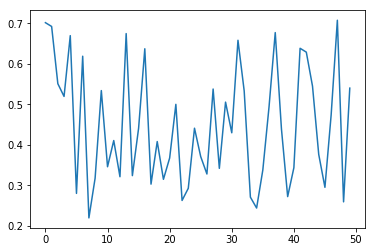

0.4478870643621249
______NOOKS_________
DAY 36


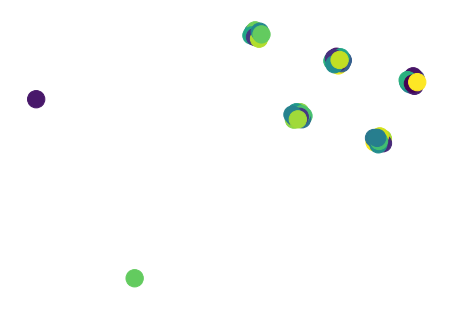

______NETWORK_________


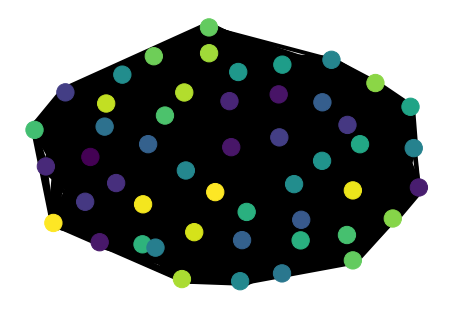

                        0         1
0    [0.9619107455346222]  0.701905
1   [0.06441444674001473]  0.692553
2    [0.7891942715303771]  0.551029
3     [0.177226238283531]  0.519554
4    [0.9440371060941252]  0.669865
5    [0.6091959154527136]  0.279865
6     [0.839591919659533]  0.618982
7    [0.4406367464203794]  0.265650
8    [0.6775089279258867]  0.317463
9   [0.17855500858877416]  0.534017
10  [0.28493851781217705]  0.370582
11  [0.11384921261232228]  0.410515
12   [0.5158618344686122]  0.321054
13   [0.9333196008170971]  0.674937
14  [0.44673635143702617]  0.323776
15   [0.7510065789639694]  0.467051
16  [0.07845944951476702]  0.672308
17     [0.57412693913227]  0.302776
18   [0.5326677331923972]  0.408007
19   [0.4687401068189414]  0.308992
20  [0.35736784515754816]  0.287442
21  [0.05295805297084666]  0.512752
22   [0.4960445674936236]  0.236553
23   [0.6919055562617197]  0.292179
24   [0.8994784804713435]  0.441005
25  [0.38438243606127953]  0.370825
26   [0.7318488841888736]  0

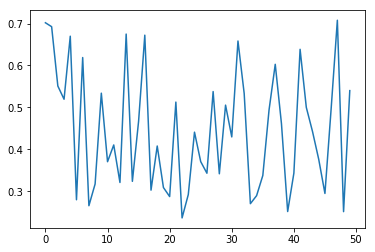

0.44402639096952357
______NOOKS_________
DAY 37


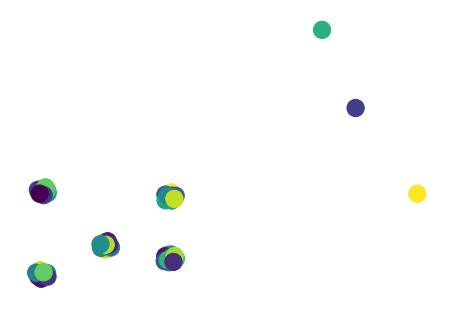

In [ ]:
member_vectors = np.random.random(size=(50, 1))
#print(sorted(member_vectors))
exp = NooksExperiment(member_vectors, alpha=1000)
exp.run(num_nooks=5)

